In [1]:
import tensorflow as tf

import matplotlib as mpl
import pickle as pkl
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

matplotlib.rcParams['figure.figsize'] = (24, 18)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams.update({'font.size': 20})

TRAIN_SIZE = 9800
TRAIN_TIME = 6
BATCH_SIZE = 32
BUFFER_SIZE = 500

In [2]:
total_ped_matrix = np.load("details/total_ped_matrix.npy")

train_set = total_ped_matrix[:TRAIN_SIZE]
test_set = total_ped_matrix[TRAIN_SIZE:]

In [5]:
kfold = KFold(5, True, 1)

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

train_acc = []
train_loss = []

for train, val in kfold.split(train_set):
    x_train = train_set[train][:, :TRAIN_TIME, :]
    x_train = x_train.reshape(-1, 42)
    y_train = train_set[train][:, TRAIN_TIME:, :2]
    y_train = y_train.reshape(-1, 20)

    x_test = train_set[val][:, :TRAIN_TIME, :]
    x_test = x_test.reshape(-1, 42)
    y_test = train_set[val][:, TRAIN_TIME:, :2]
    y_test = y_test.reshape(-1, 20)
    
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_data = val_data.batch(BATCH_SIZE).repeat()
    
    
    # defining the model
    fc_model = tf.keras.models.Sequential()
    fc_model.add(tf.keras.layers.Dense(64,
                                       input_shape=(x_train.shape[1],)))
    fc_model.add(tf.keras.layers.Dense(32, activation='relu'))
    fc_model.add(tf.keras.layers.Dense(20, activation='linear'))

    fc_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse', 
                     metrics=["accuracy"])
    
    train_history = fc_model.fit(train_data, epochs=10,
                                 verbose=0,
                                 steps_per_epoch=300,
                                 )
    scores = fc_model.evaluate(val_data, steps=60, verbose=0)
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    train_acc.append(train_history.history["accuracy"][-1])    
    train_loss.append(train_history.history["loss"][-1])

In [8]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1}')    
    print(f'> Val_Loss: {loss_per_fold[i]} - Val_Accuracy: {acc_per_fold[i]}')    
    print(f'> Train_Loss: {train_loss[i]} - Train_Accuracy: {train_acc[i]*100.}')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1
> Val_Loss: 0.13993563428521155 - Val_Accuracy: 82.70833492279053
> Train_Loss: 0.15291104755053916 - Train_Accuracy: 81.6770851612091
------------------------------------------------------------------------
> Fold 2
> Val_Loss: 0.1425553334876895 - Val_Accuracy: 82.03125
> Train_Loss: 0.1531174294402202 - Train_Accuracy: 82.53124952316284
------------------------------------------------------------------------
> Fold 3
> Val_Loss: 0.1529688601071636 - Val_Accuracy: 80.20833134651184
> Train_Loss: 0.14083980962634088 - Train_Accuracy: 82.08333253860474
------------------------------------------------------------------------
> Fold 4
> Val_Loss: 0.1633690046146512 - Val_Accuracy: 82.76041746139526
> Train_Loss: 0.14332010546078286 - Train_Accuracy: 81.84375166893005
------------------------------------------------------

In [9]:
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 81.81249976158142 (+- 0.9520868925988089)
> Loss: 0.14726794179528951
------------------------------------------------------------------------


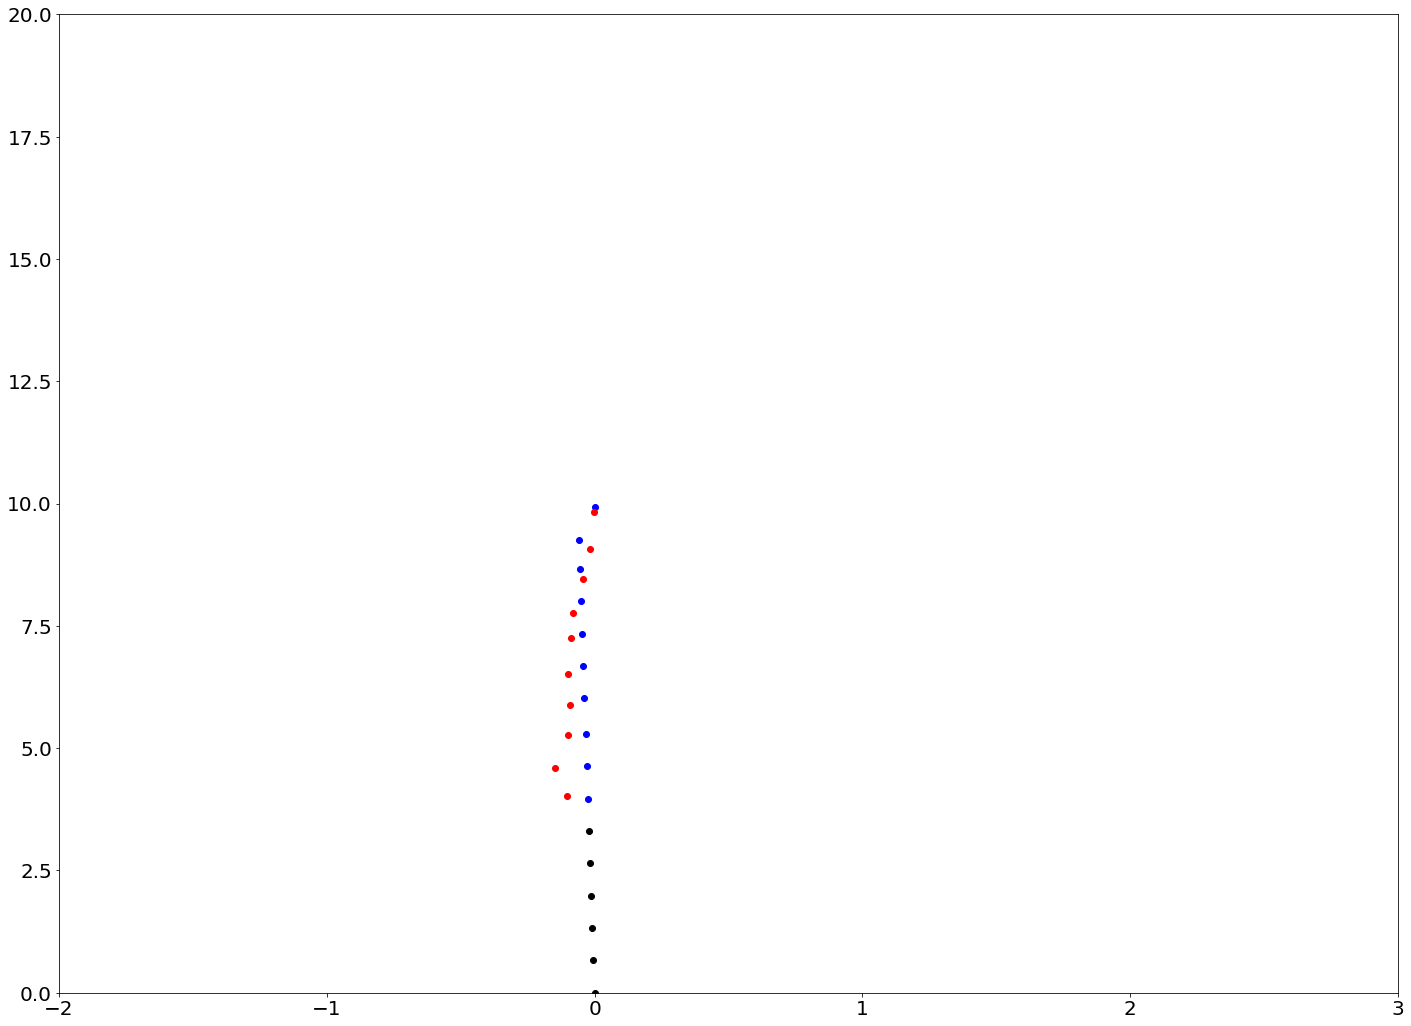

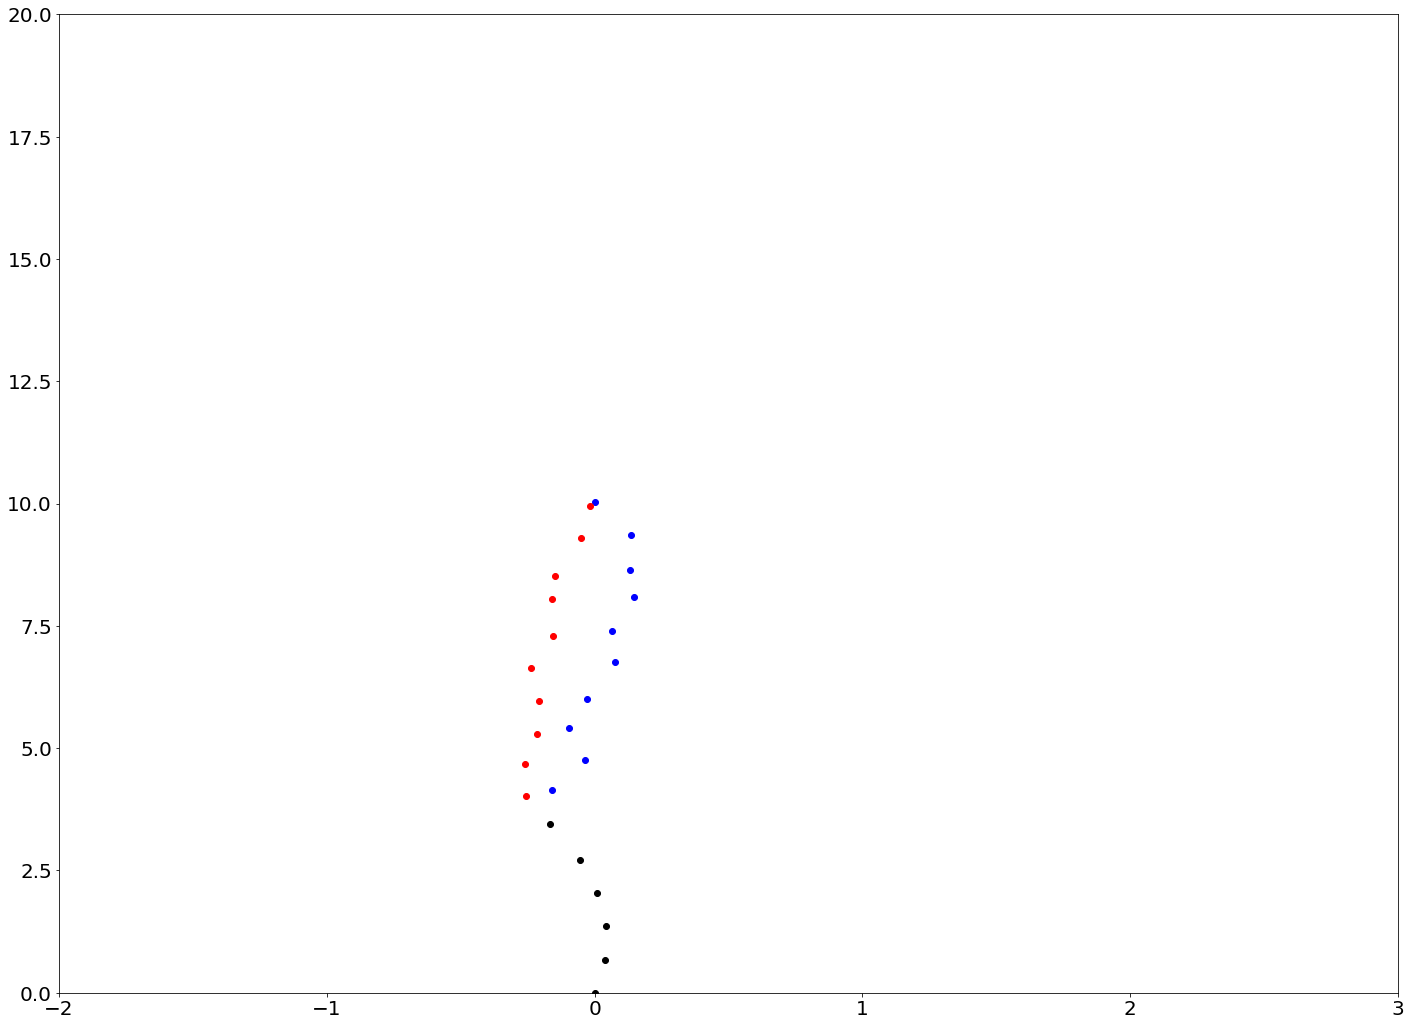

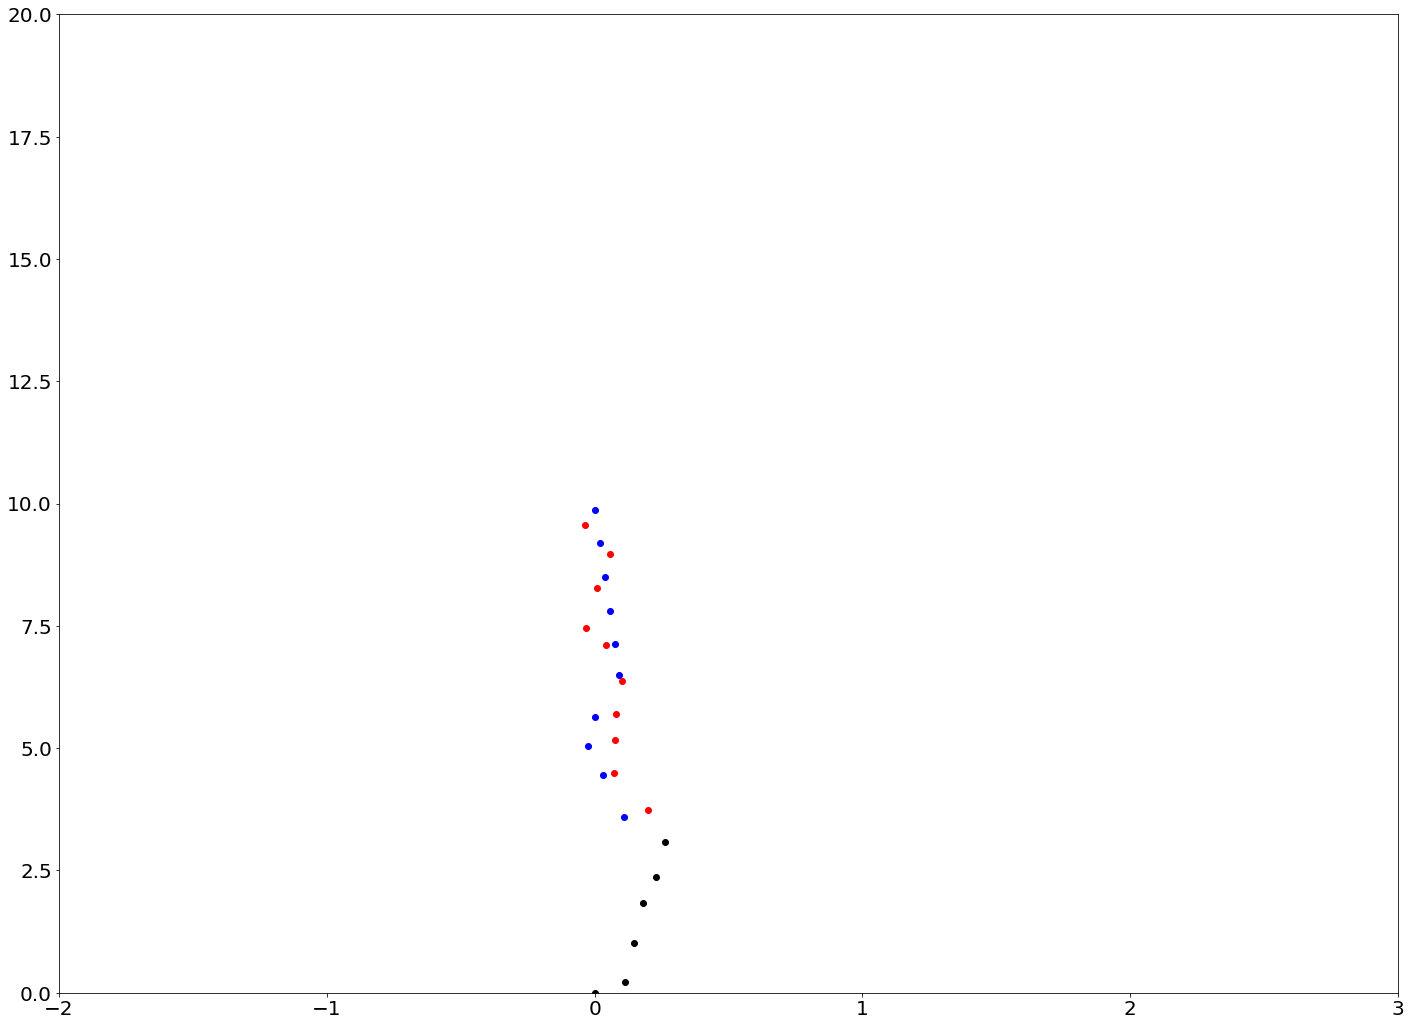

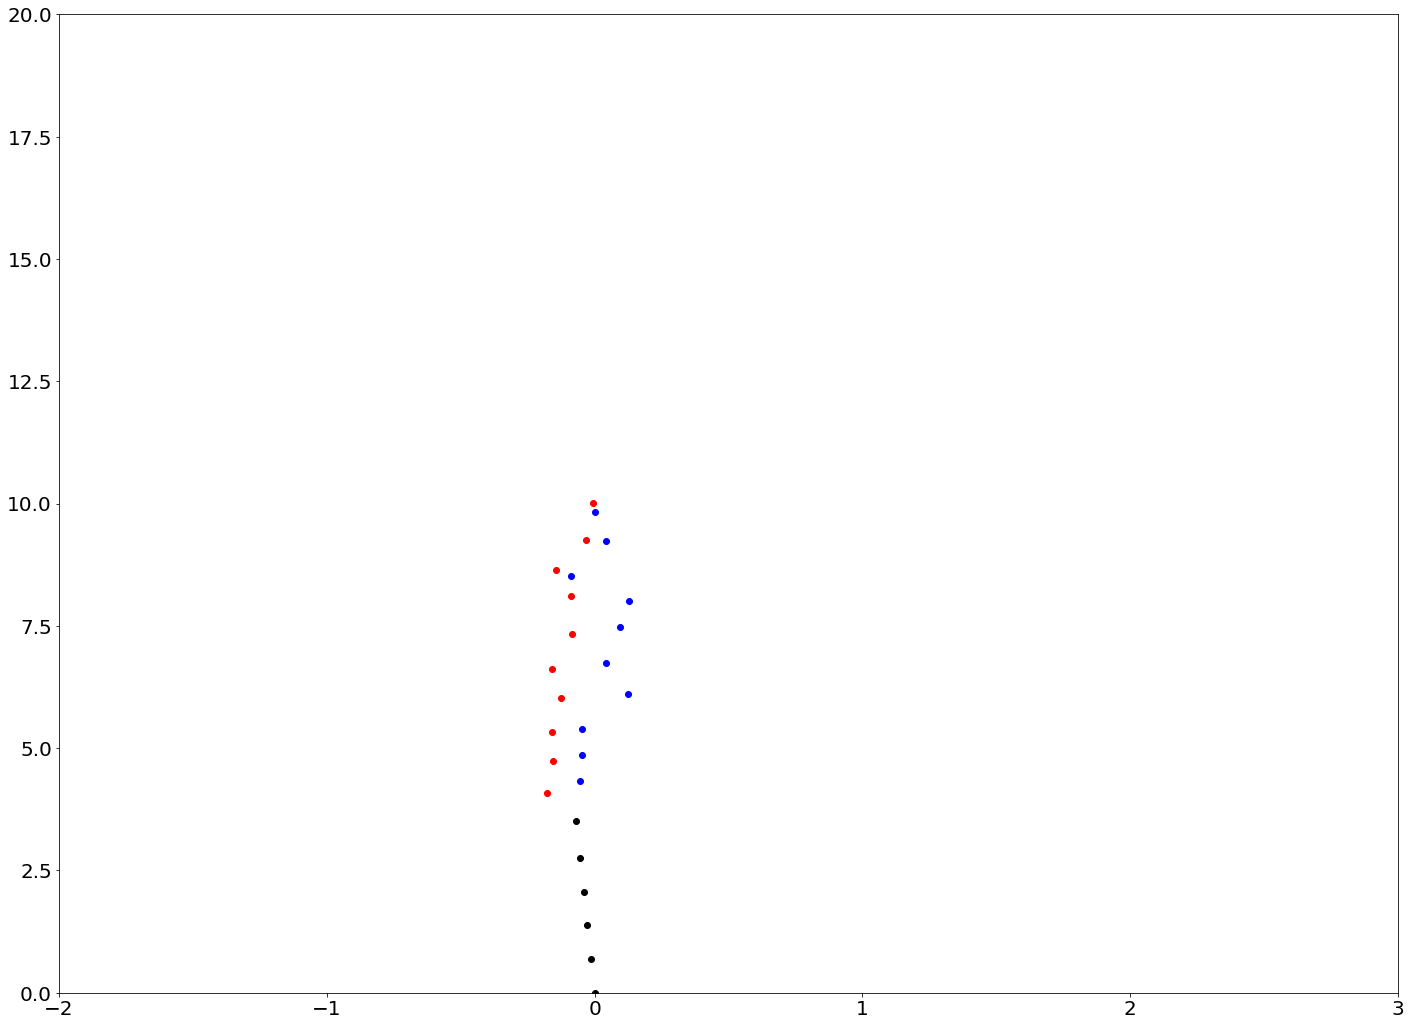

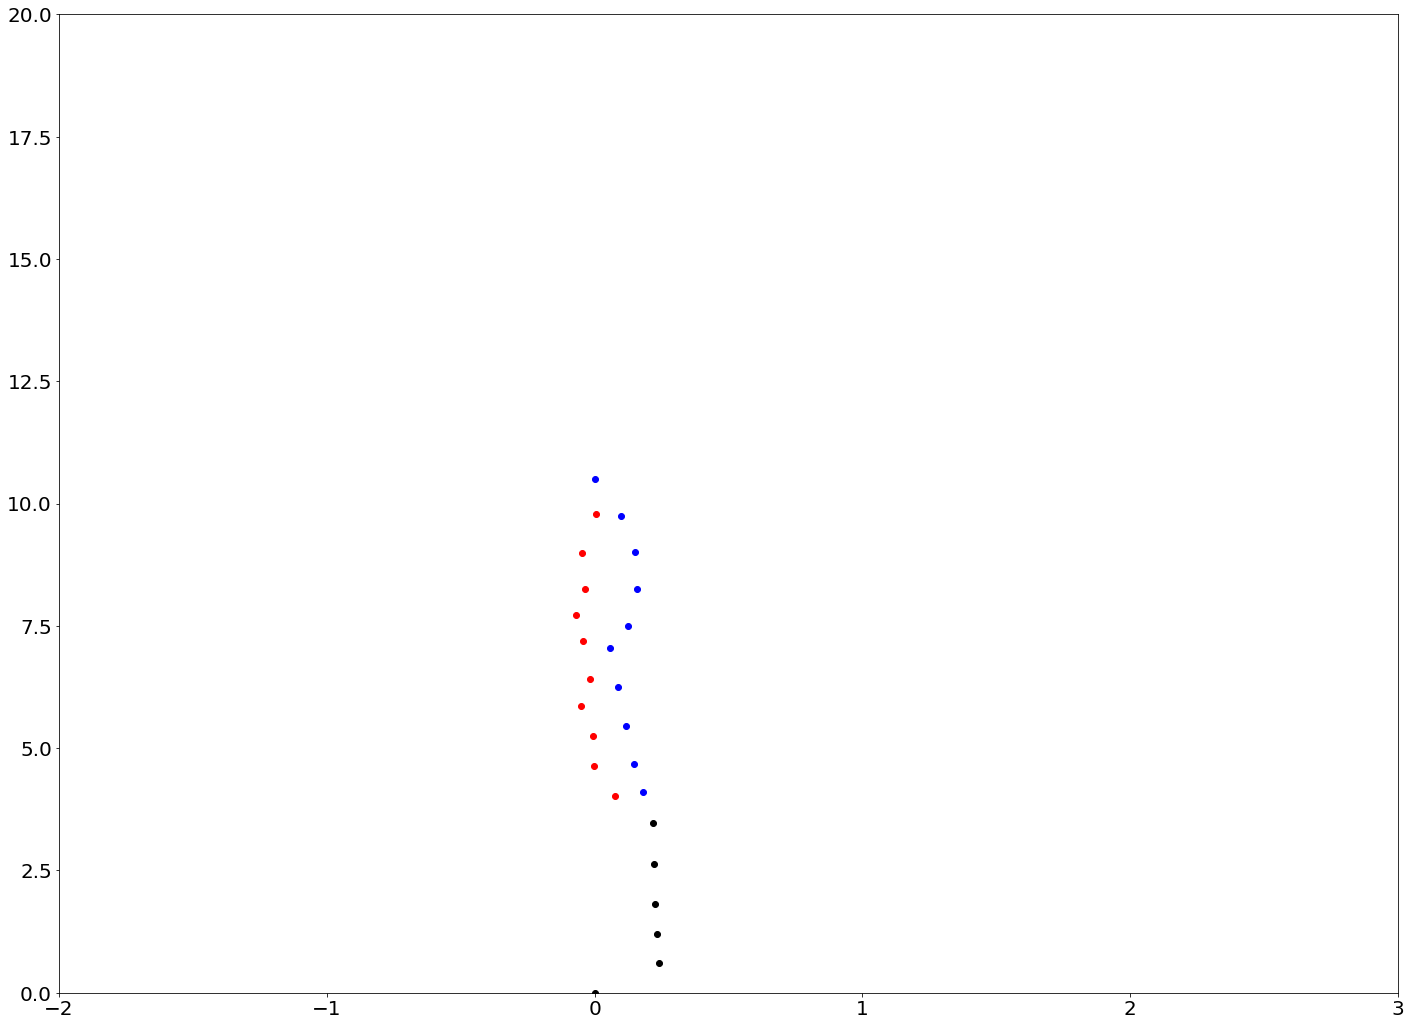

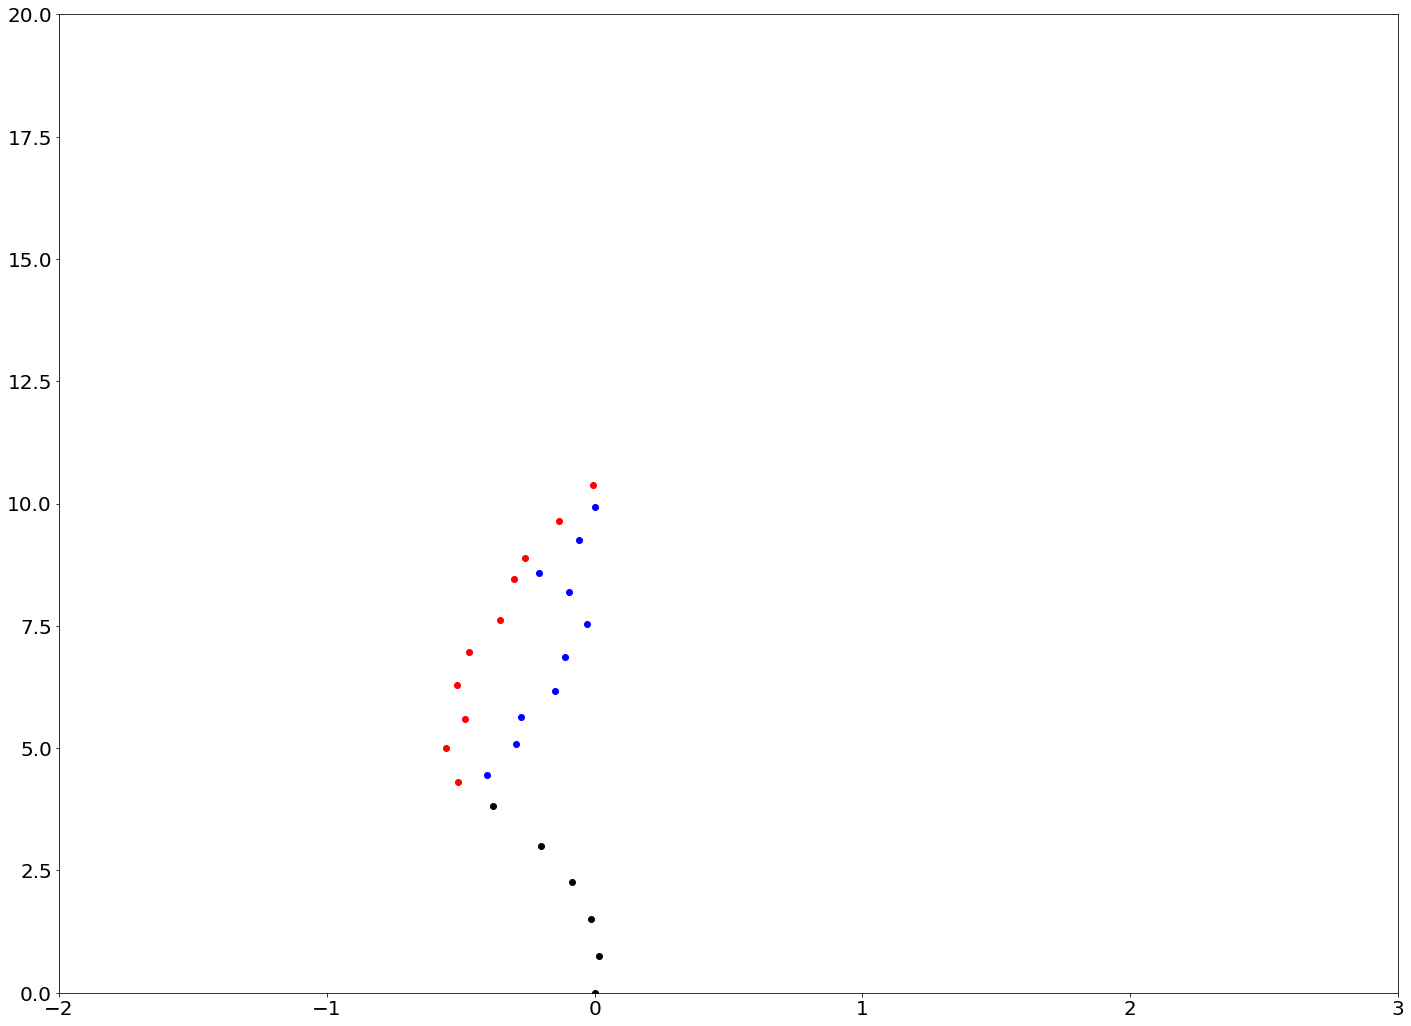

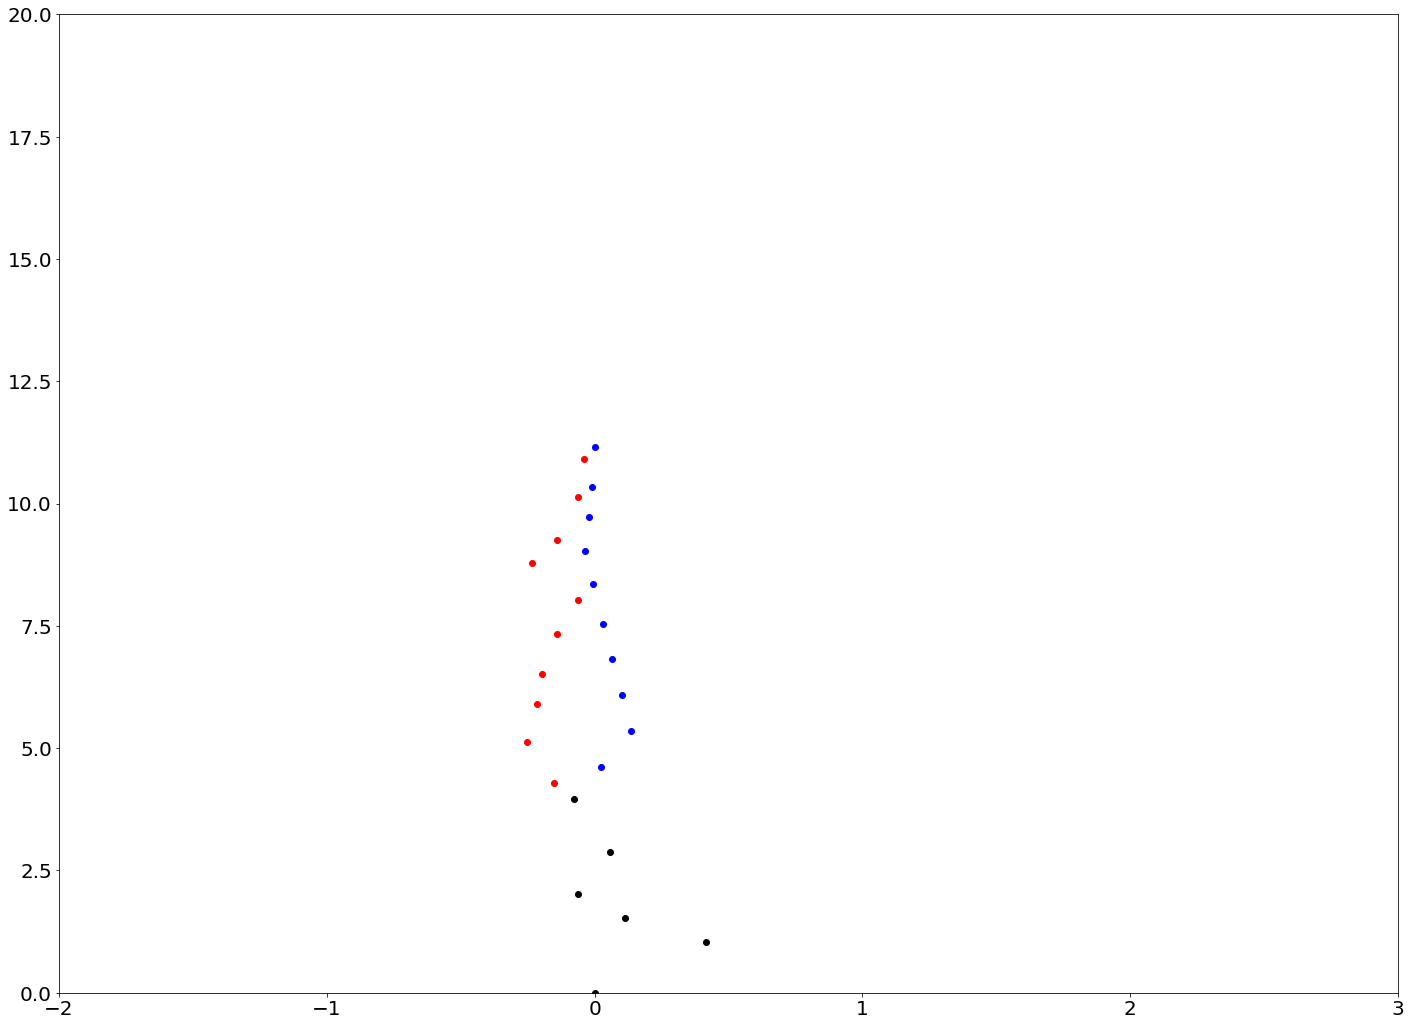

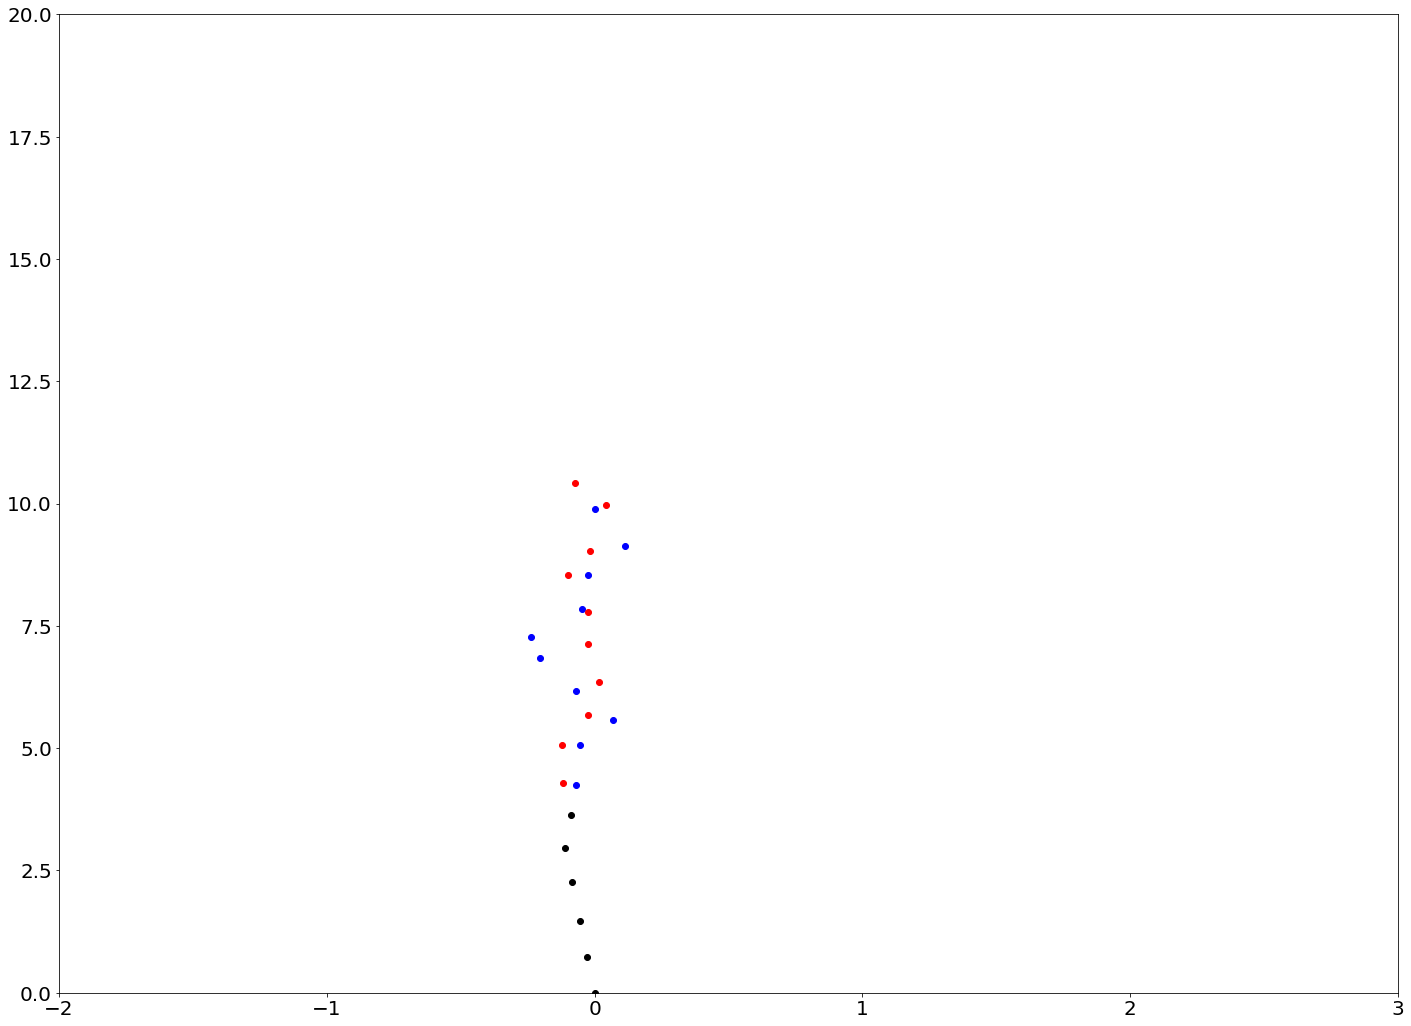

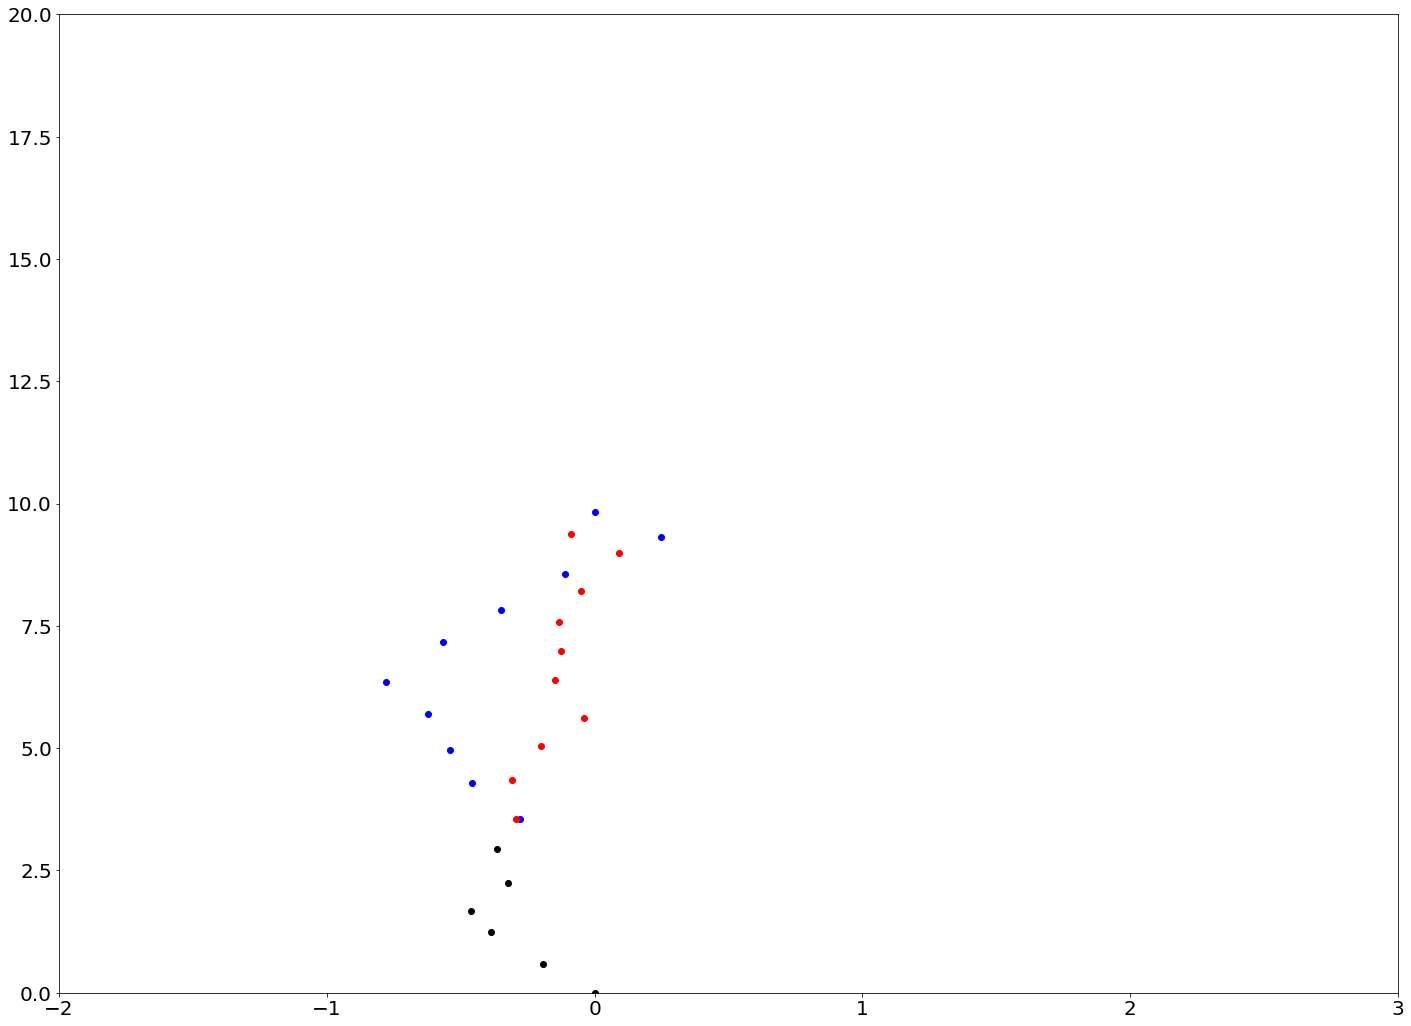

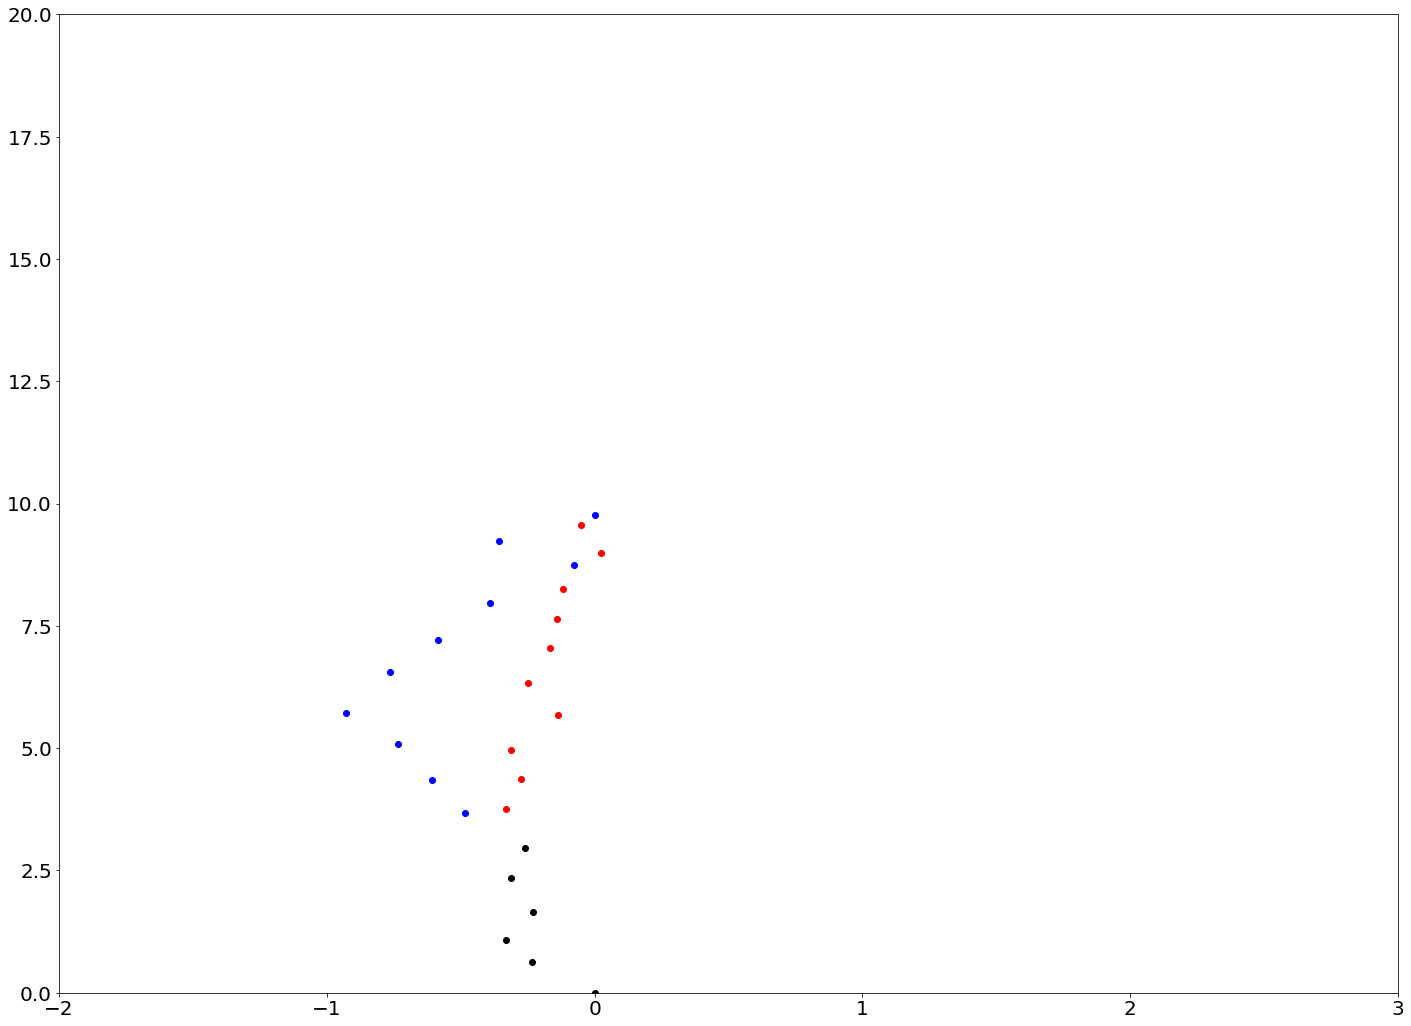

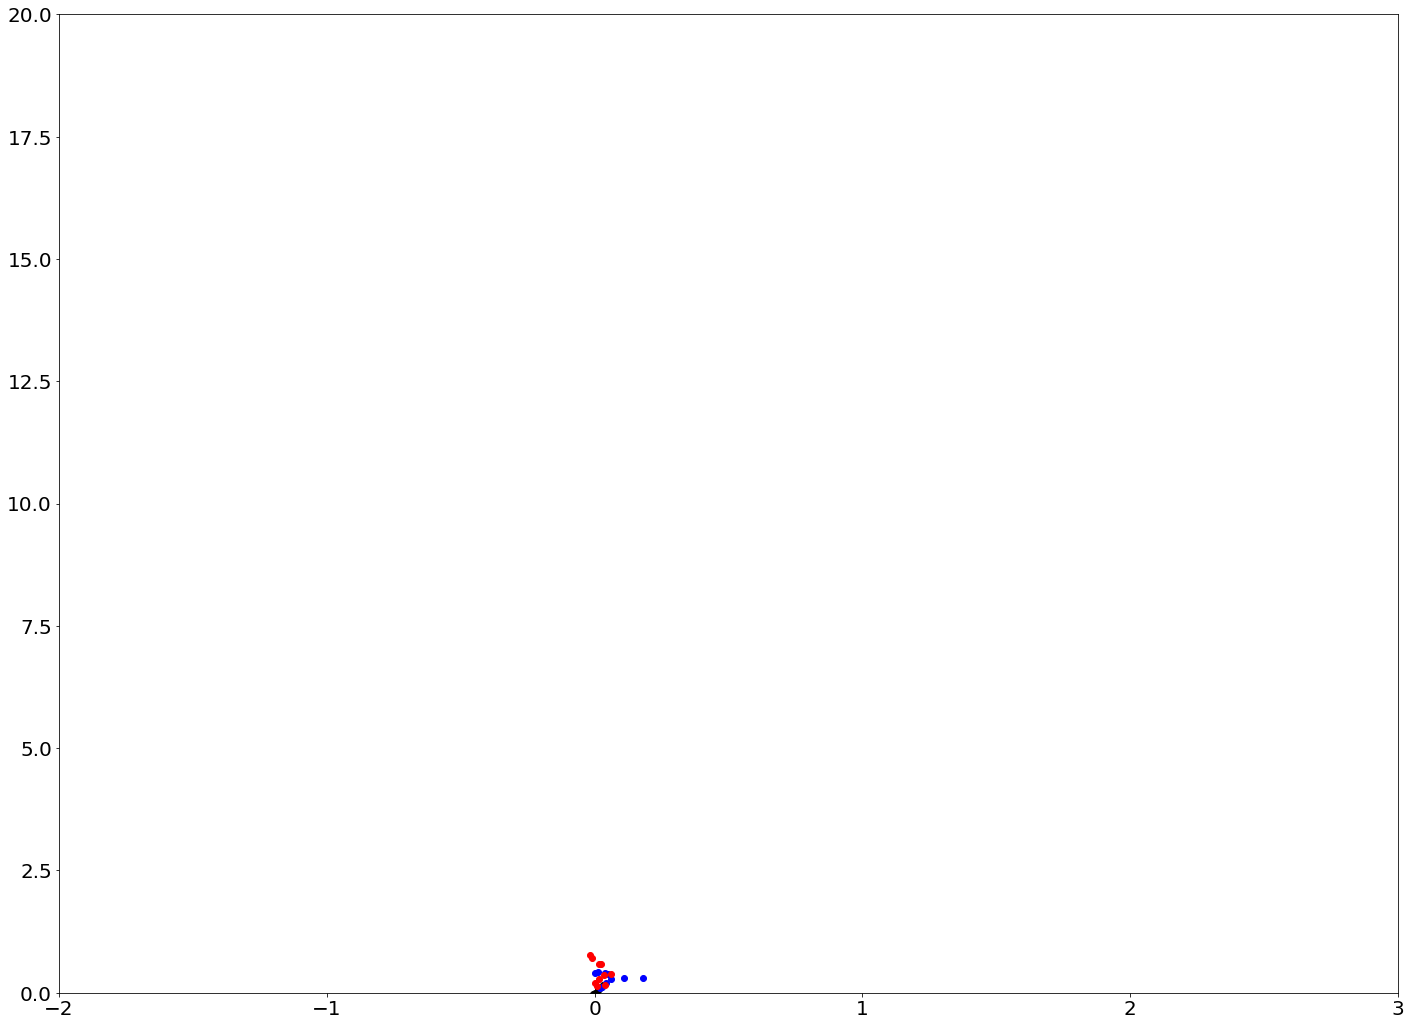

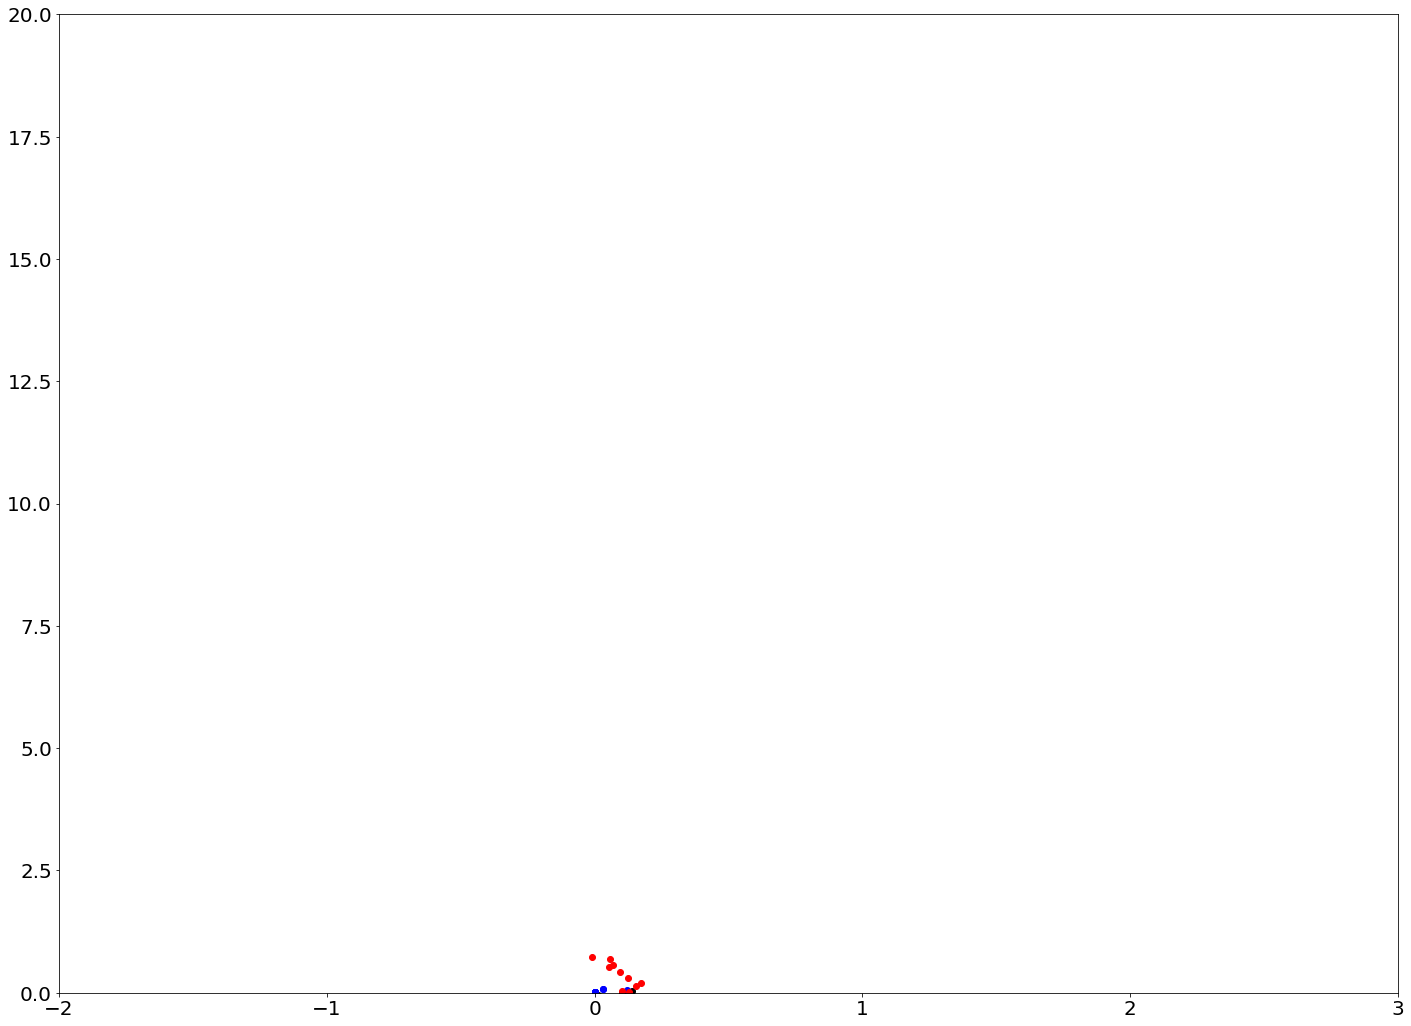

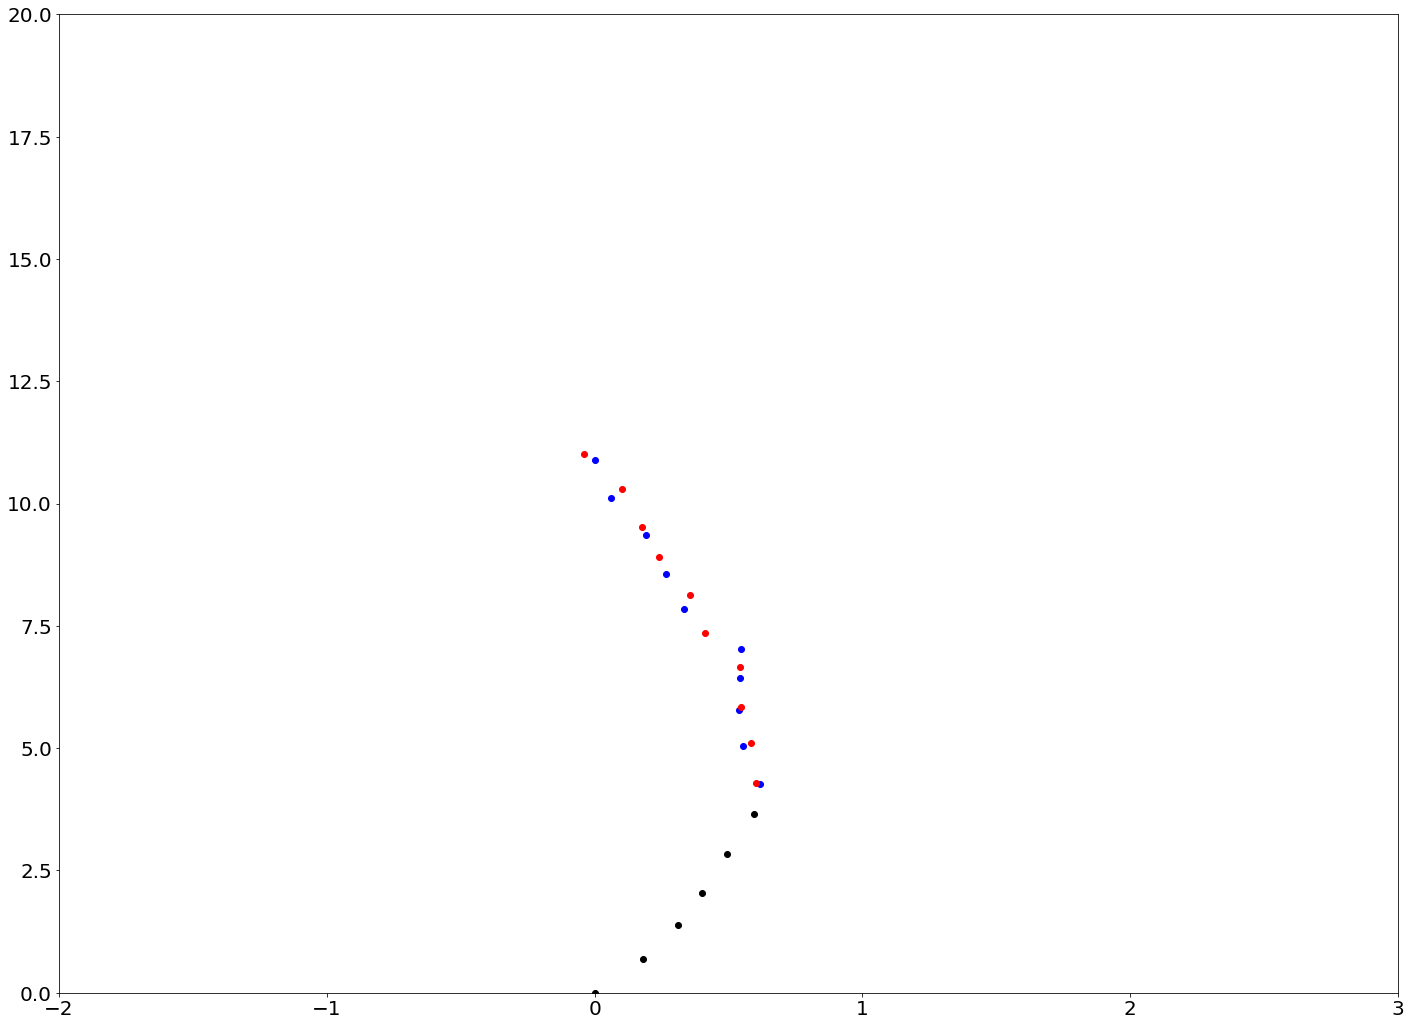

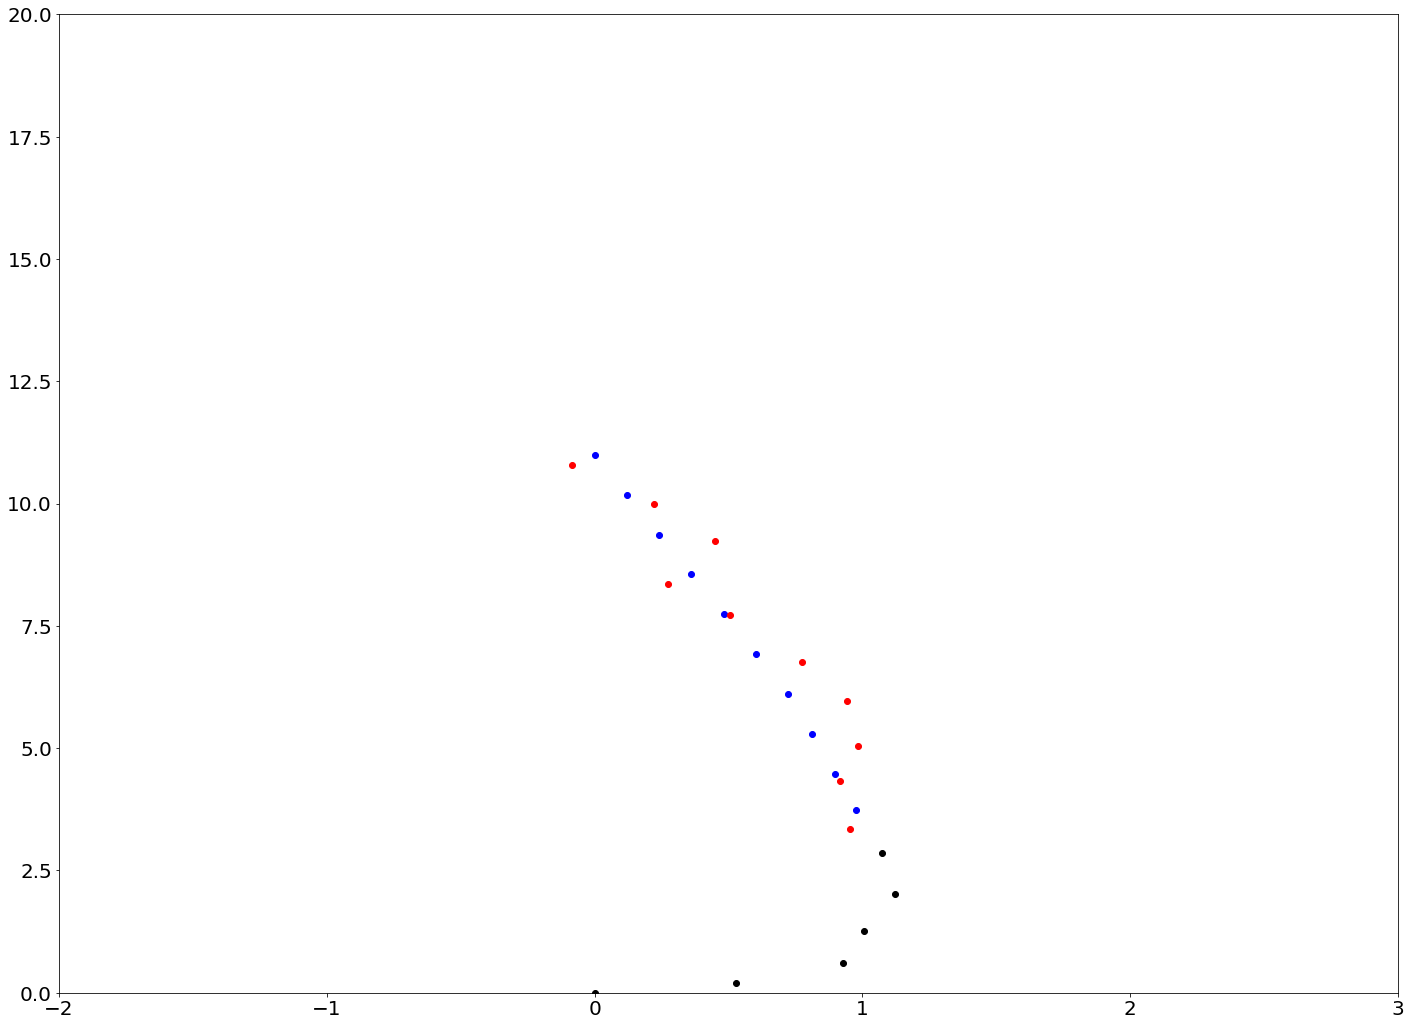

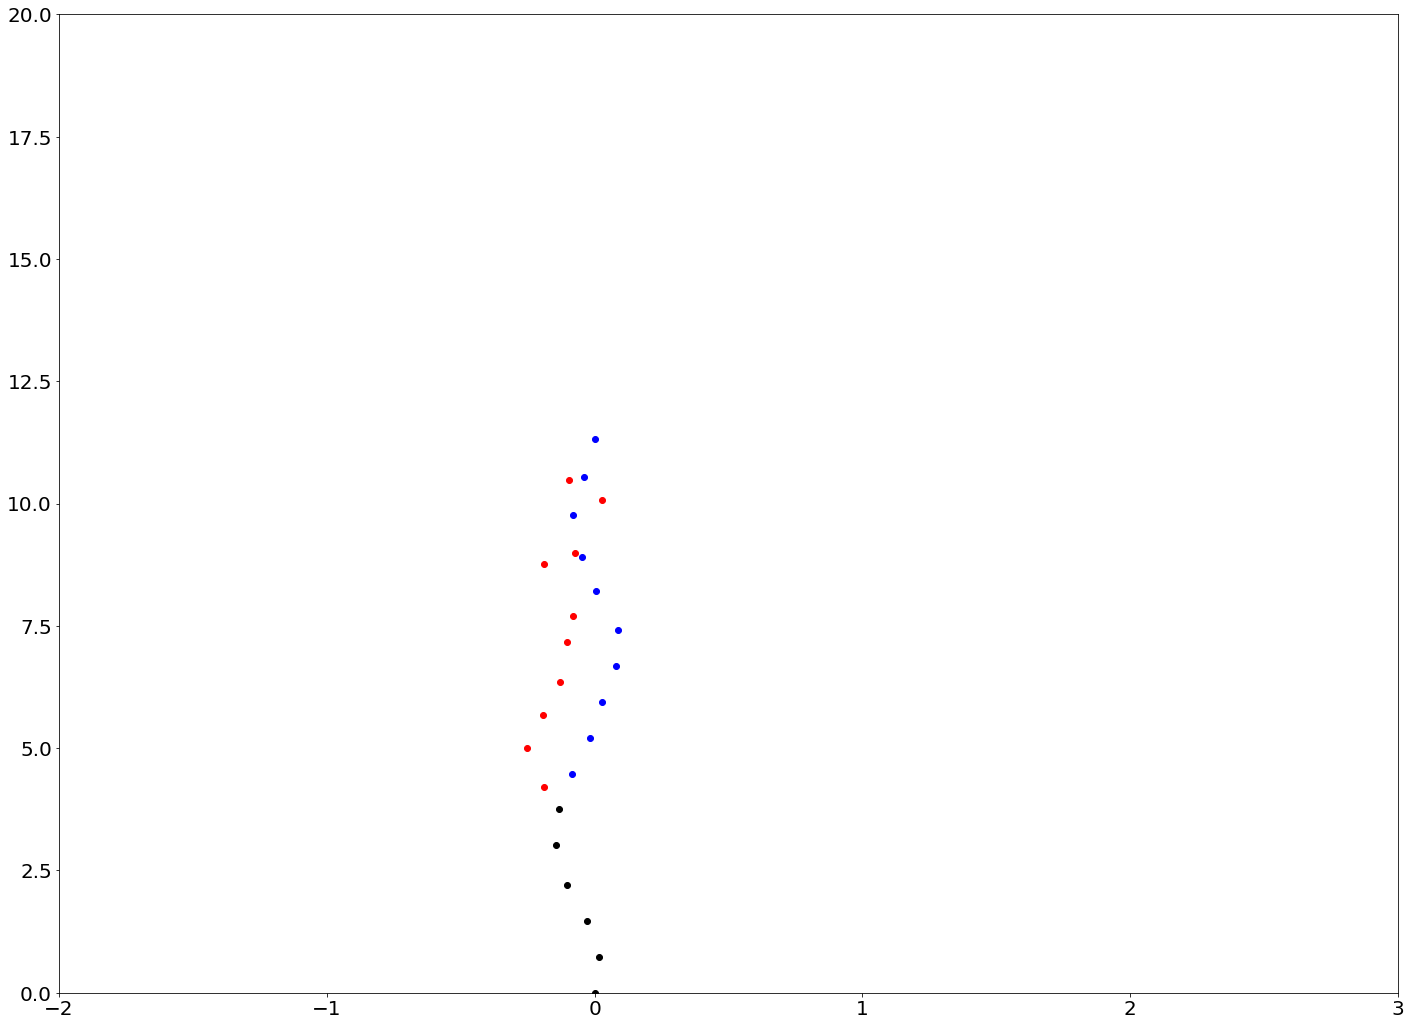

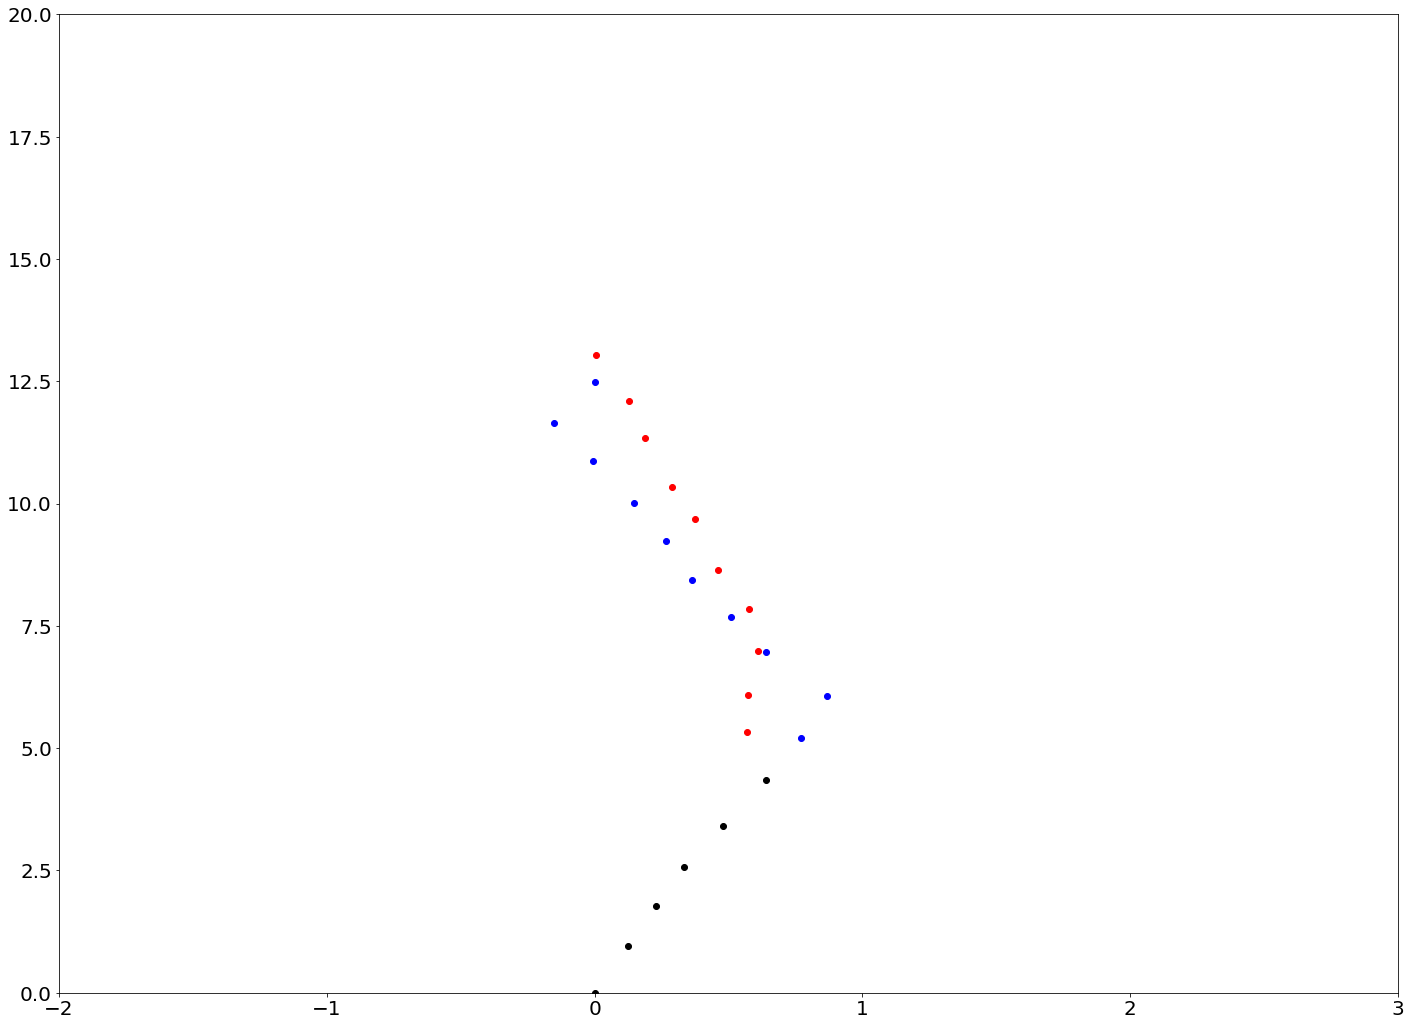

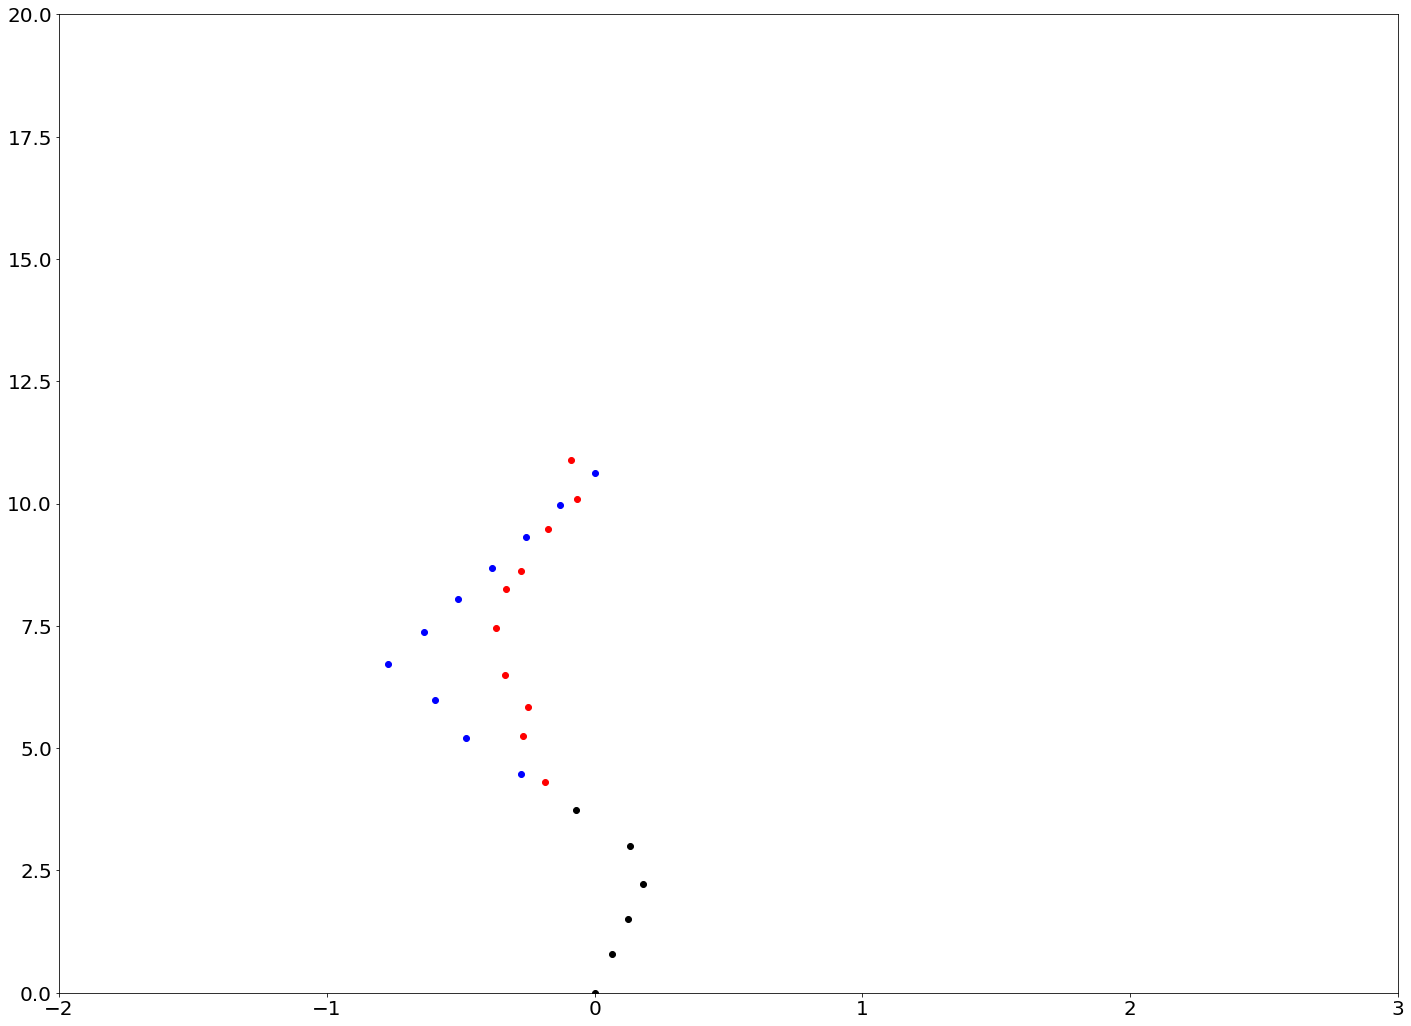

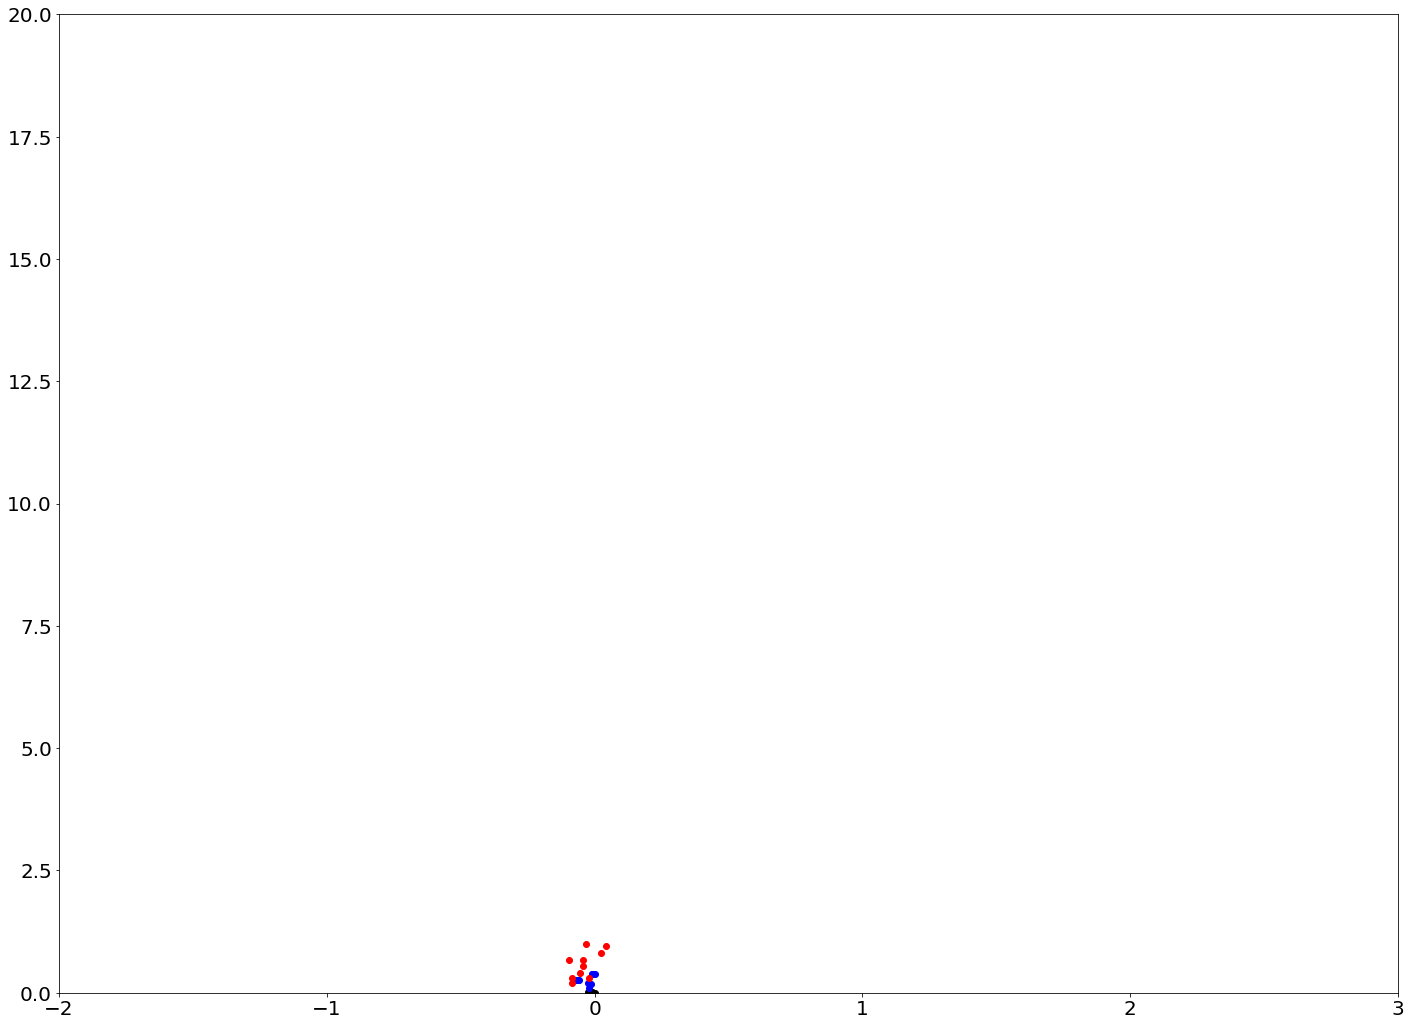

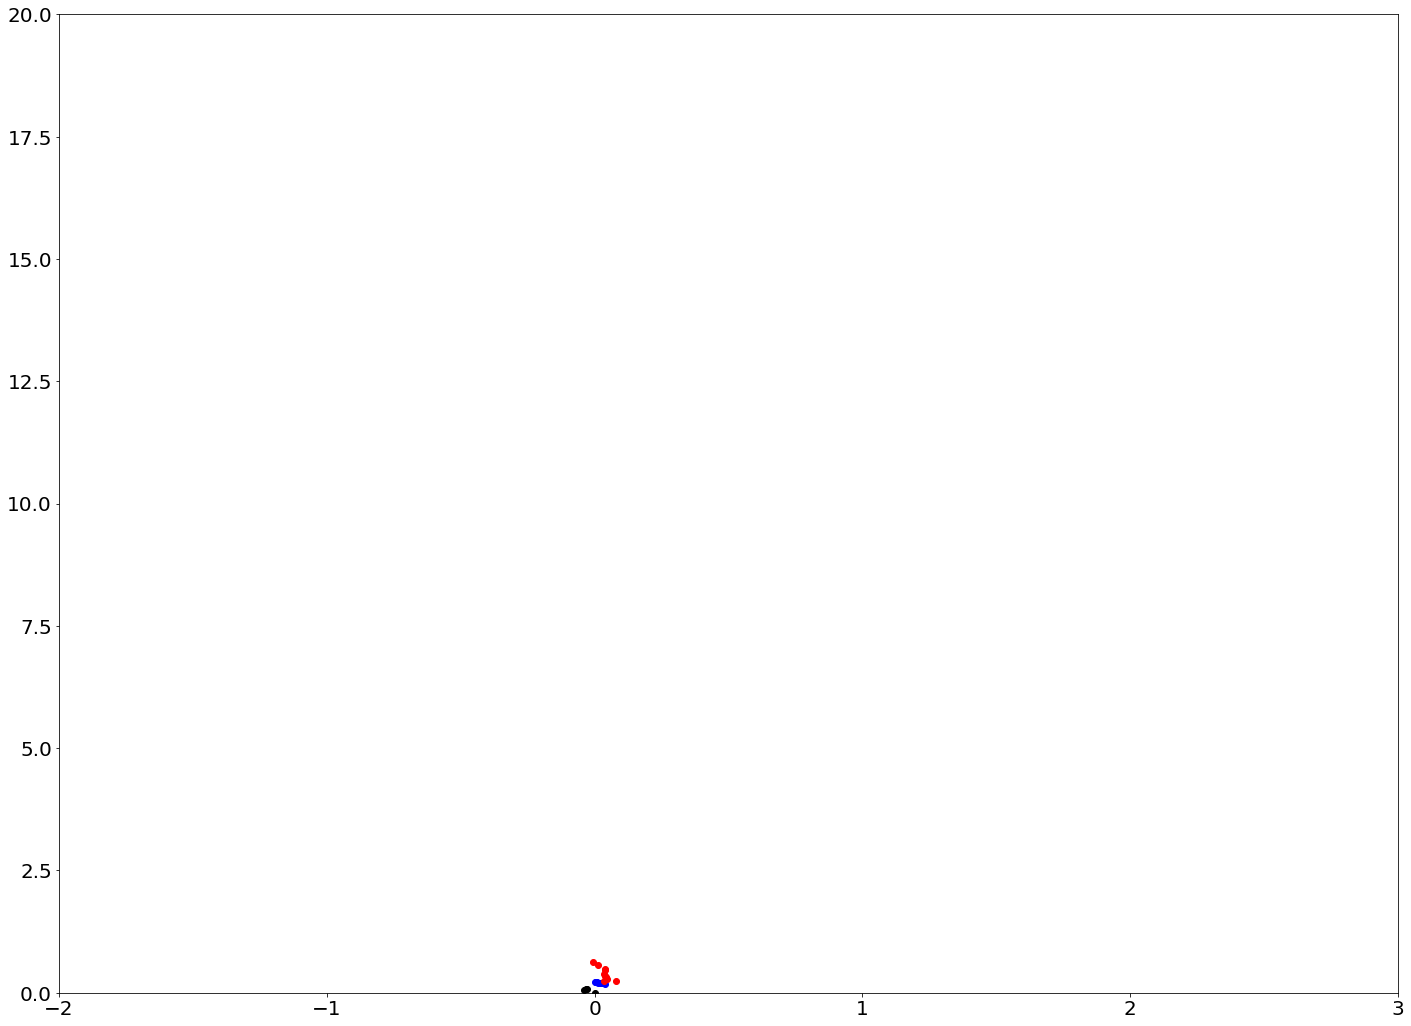

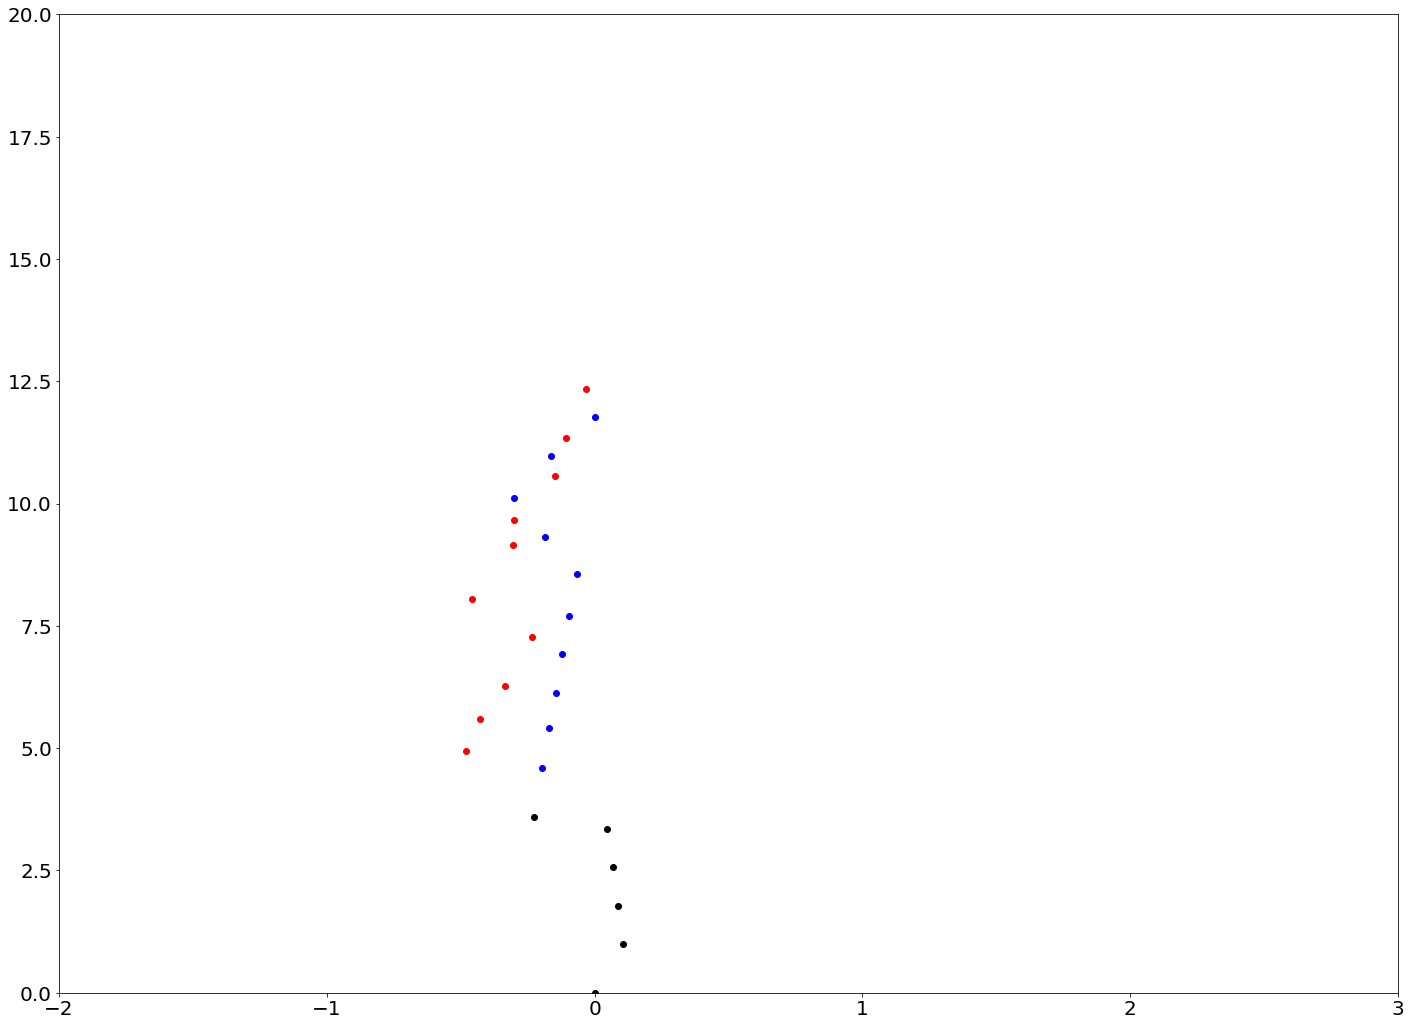

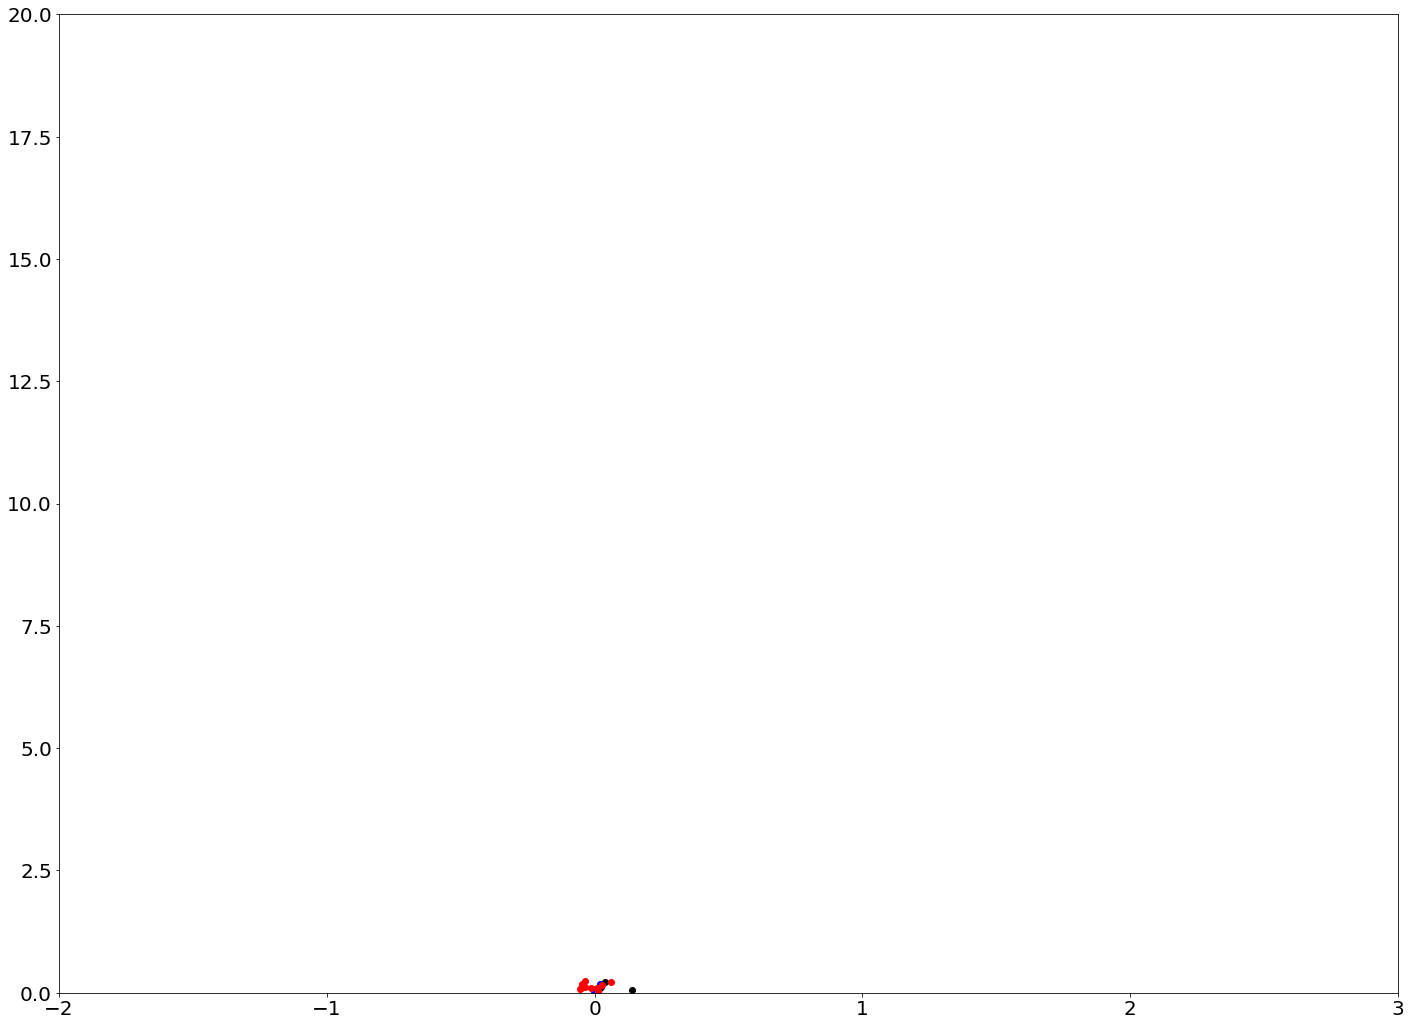

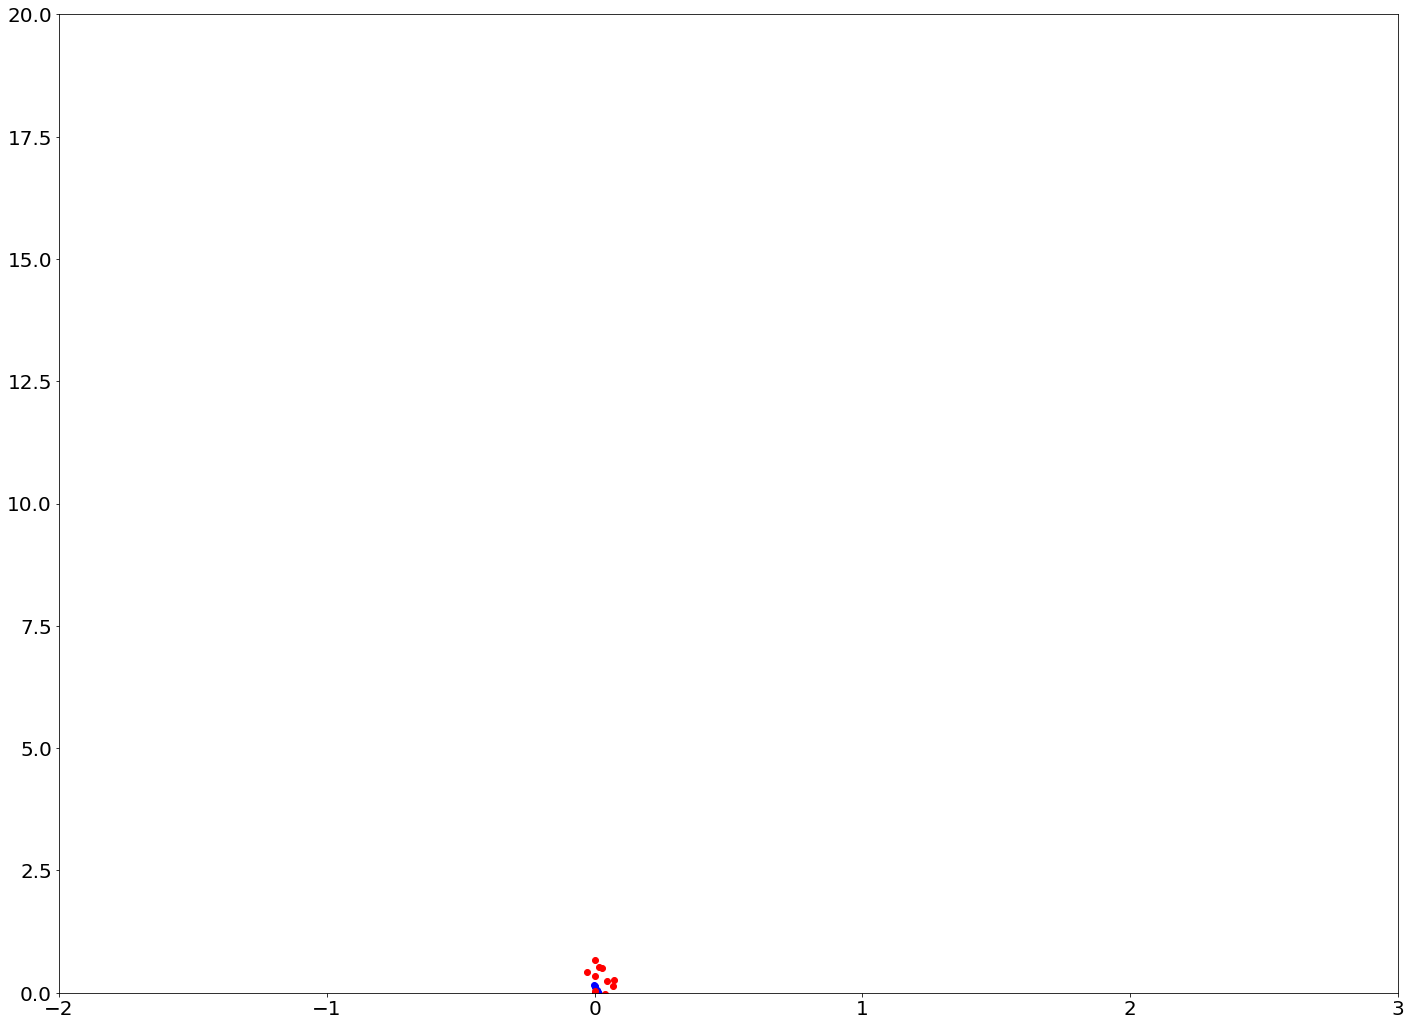

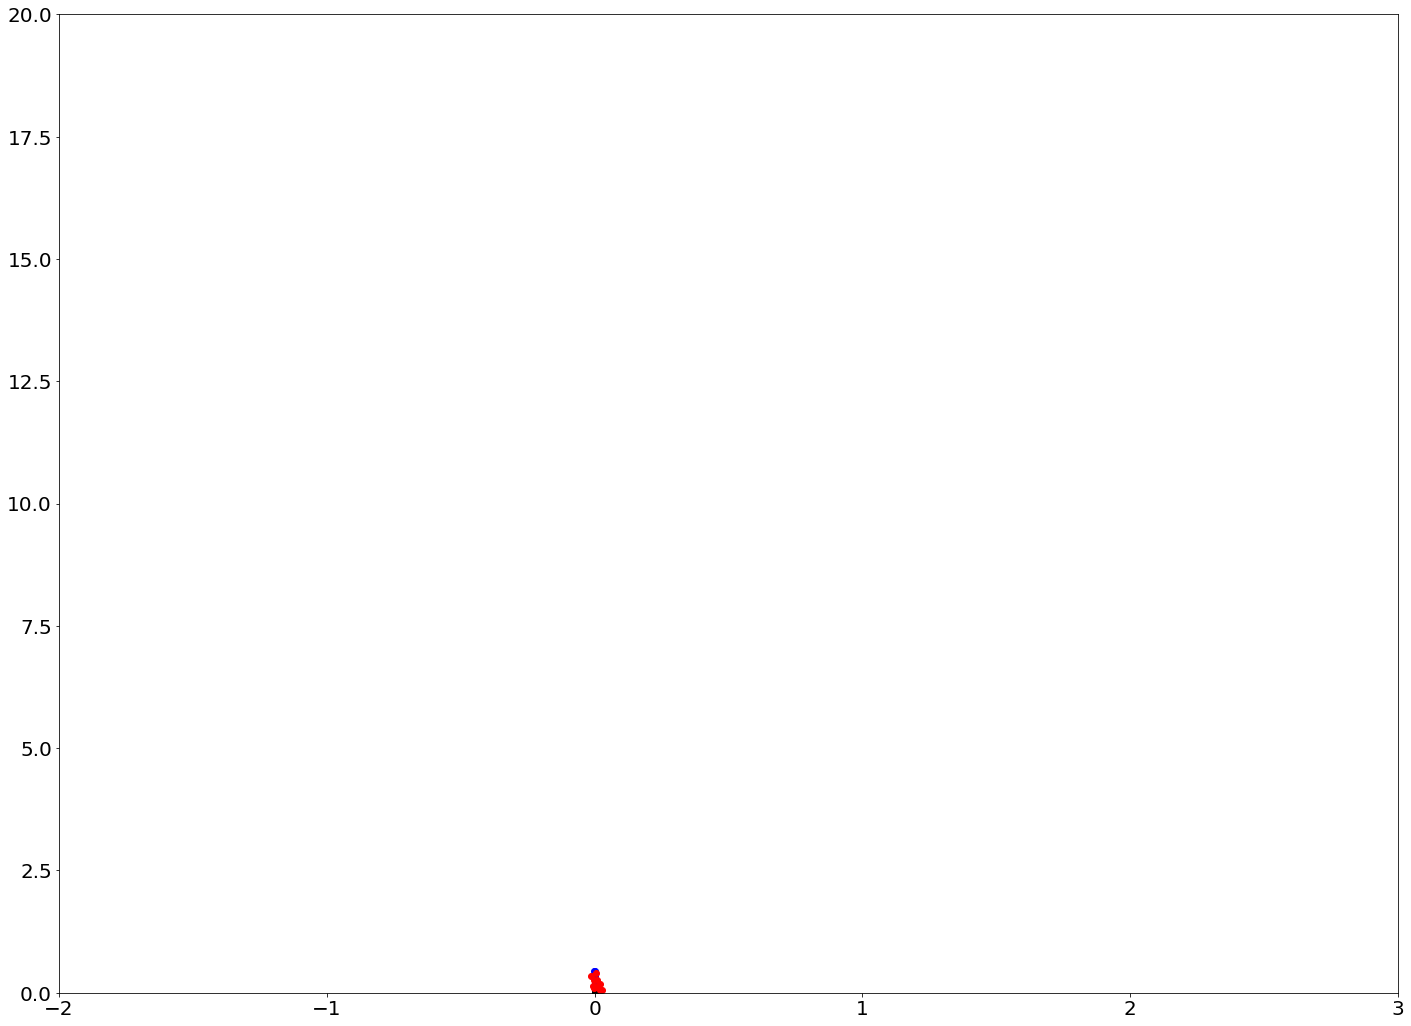

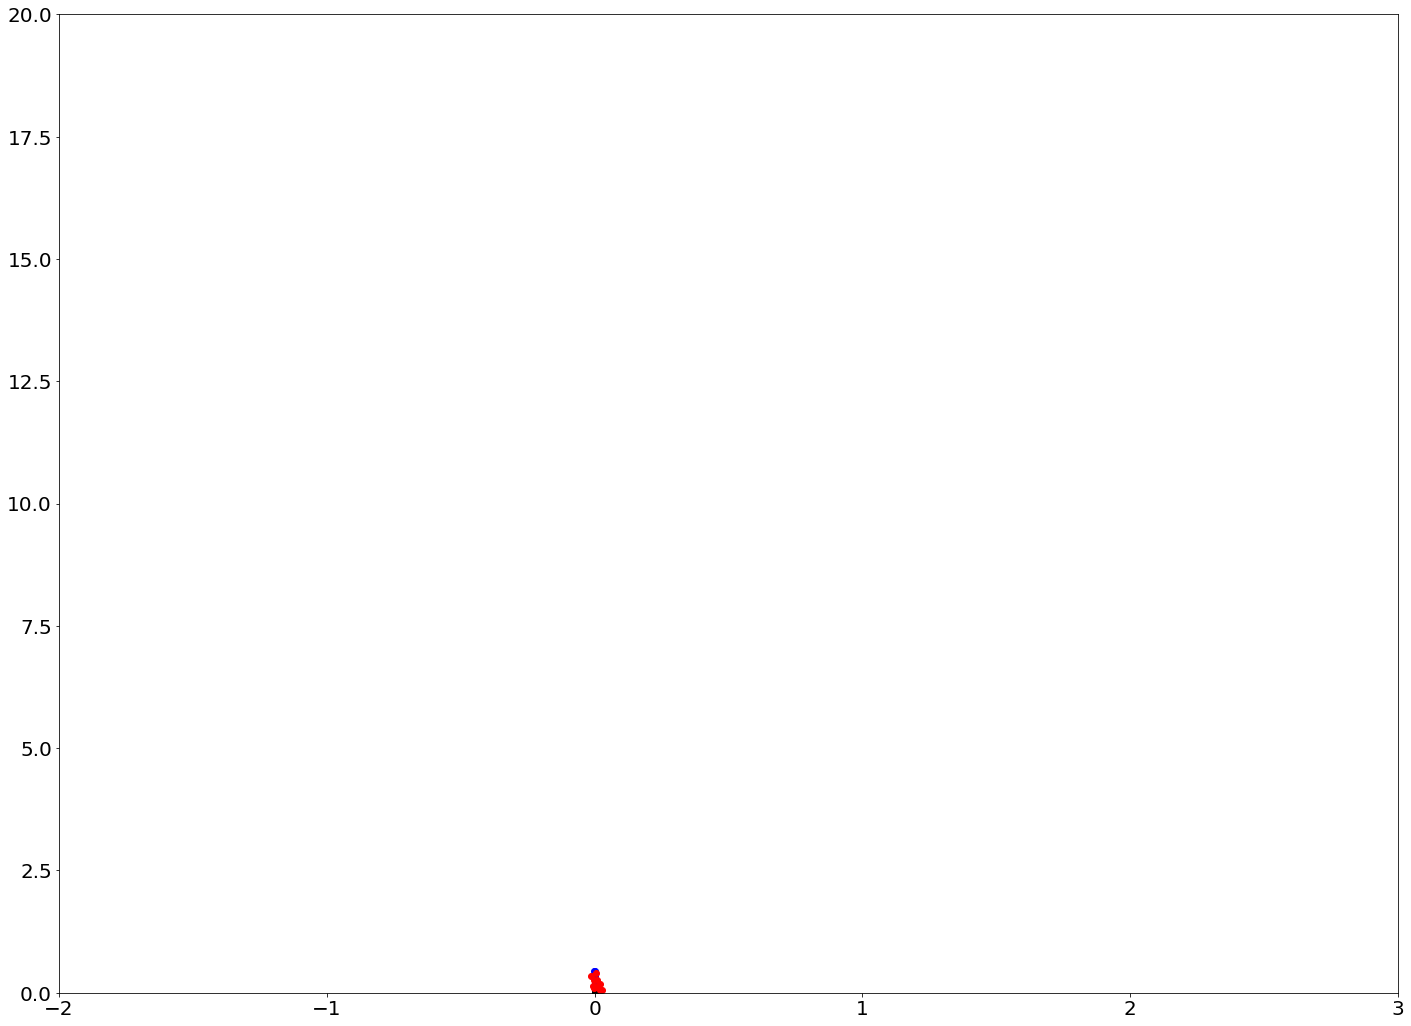

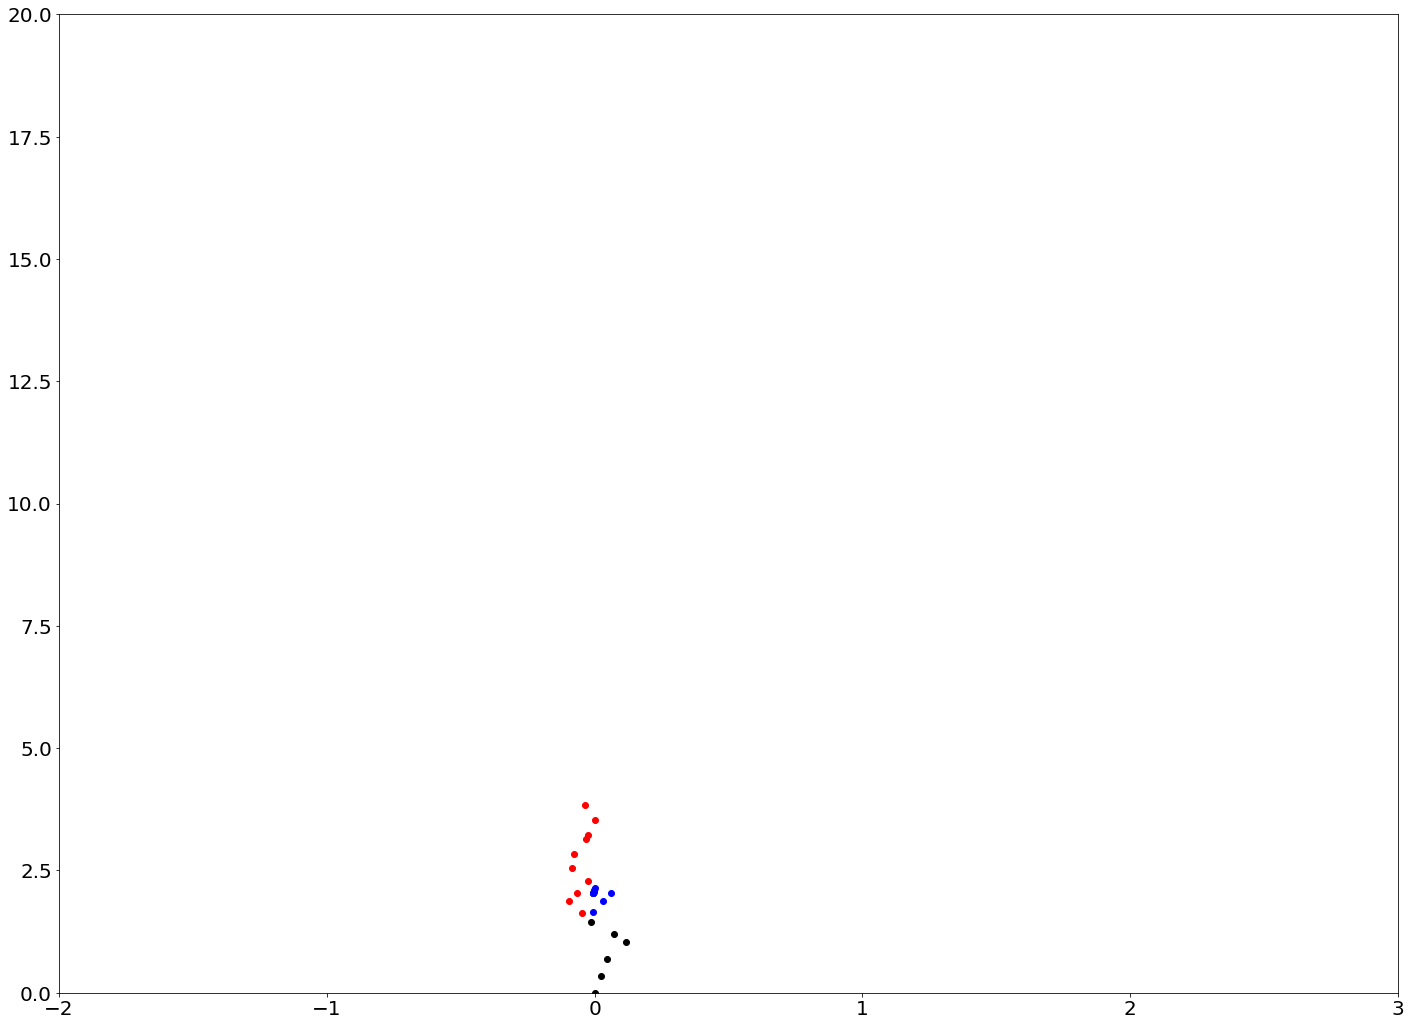

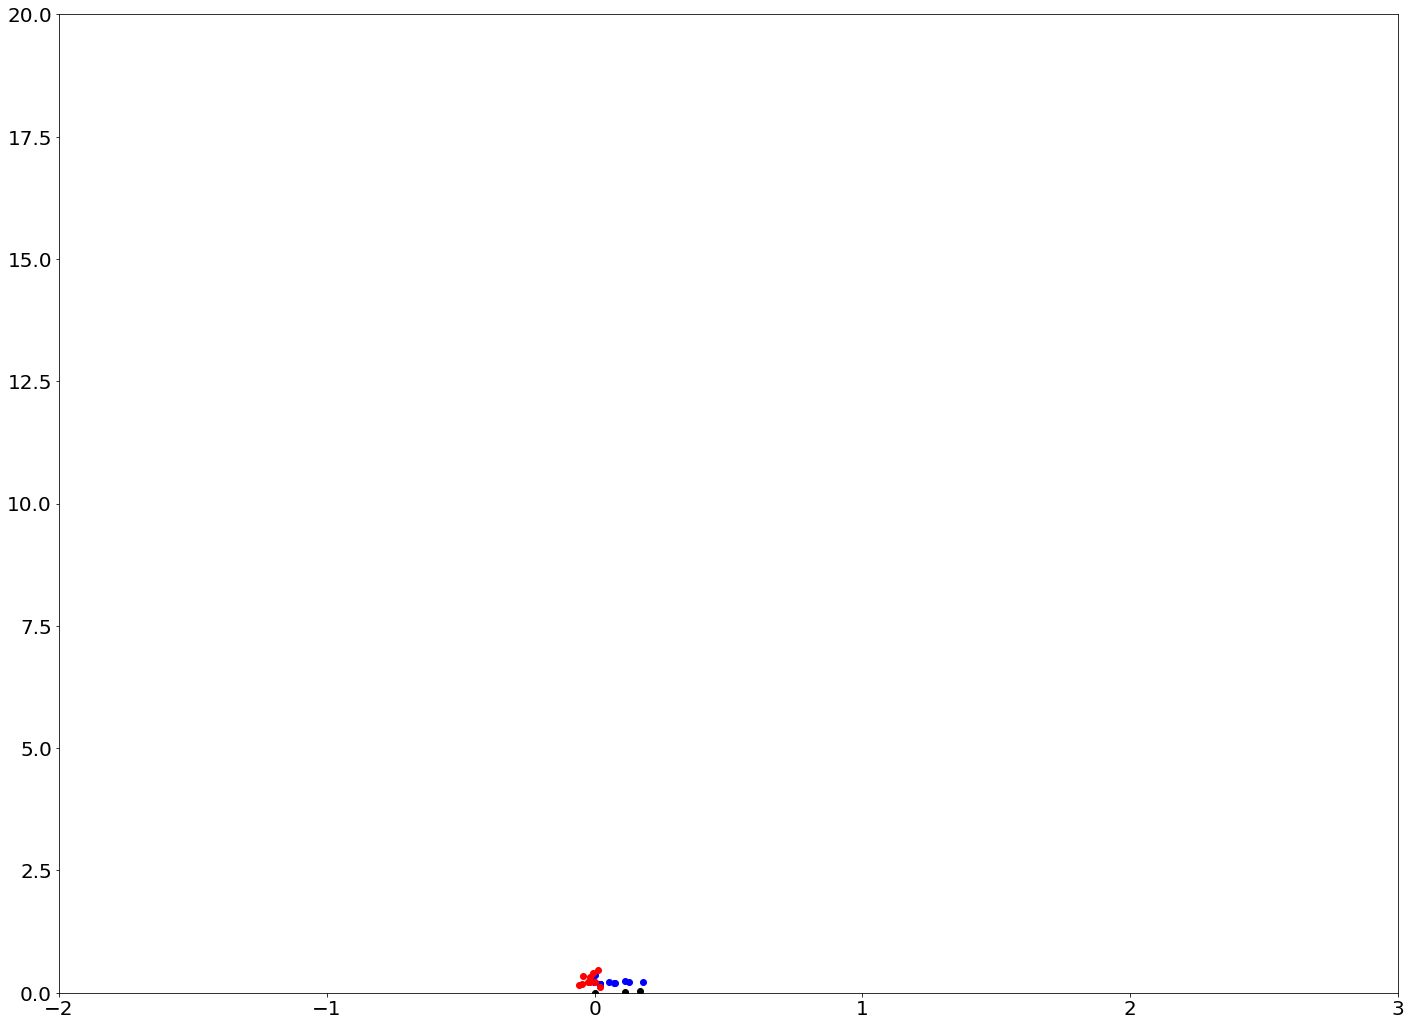

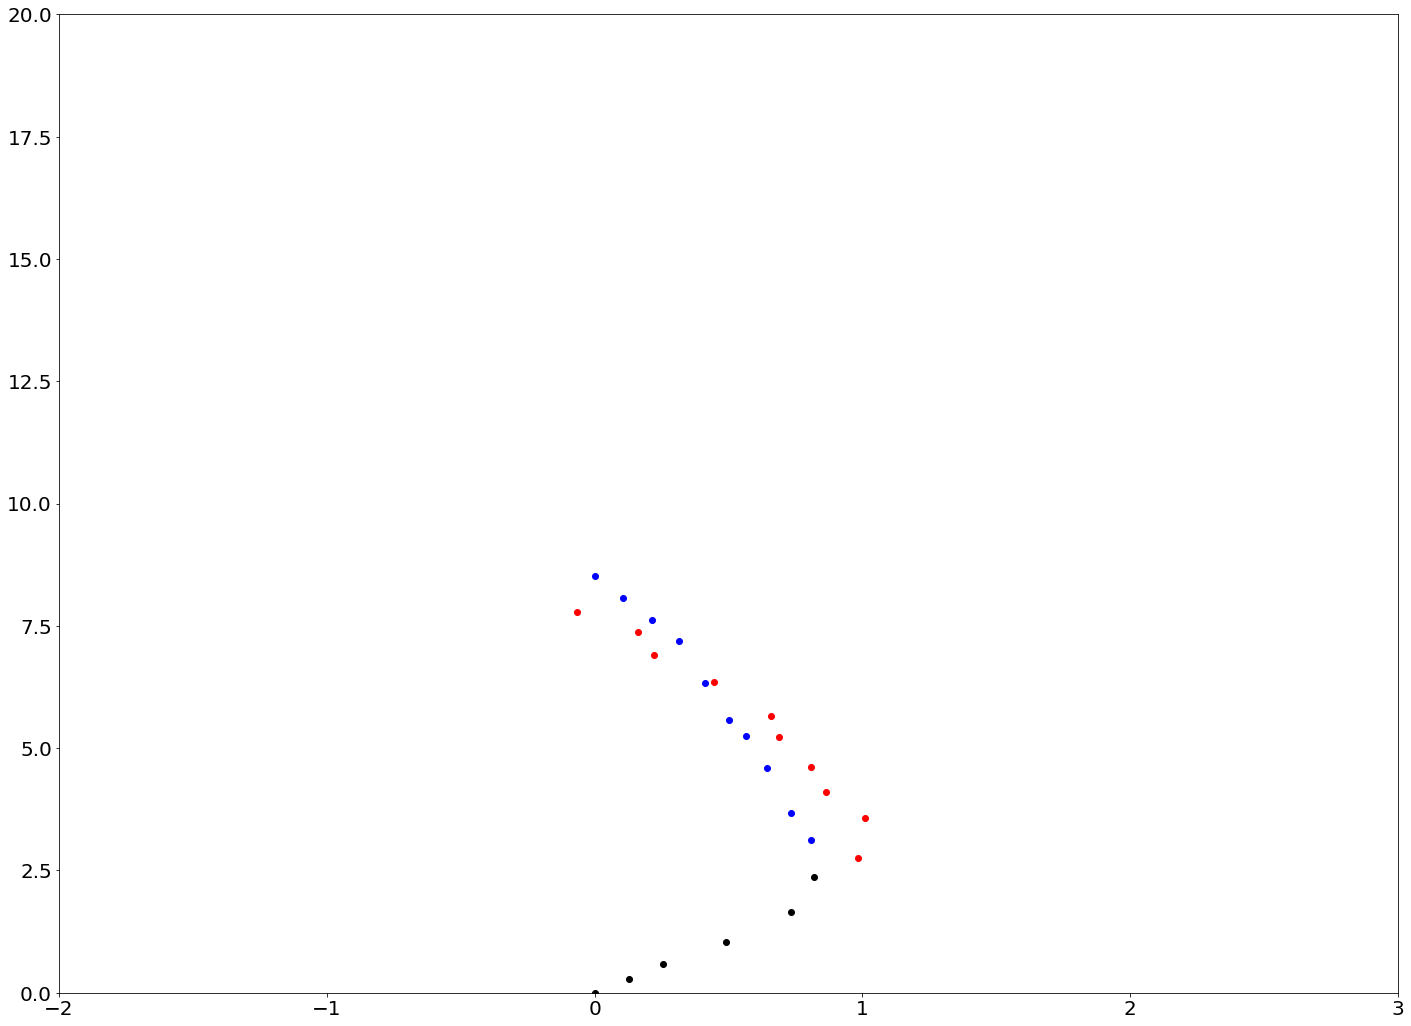

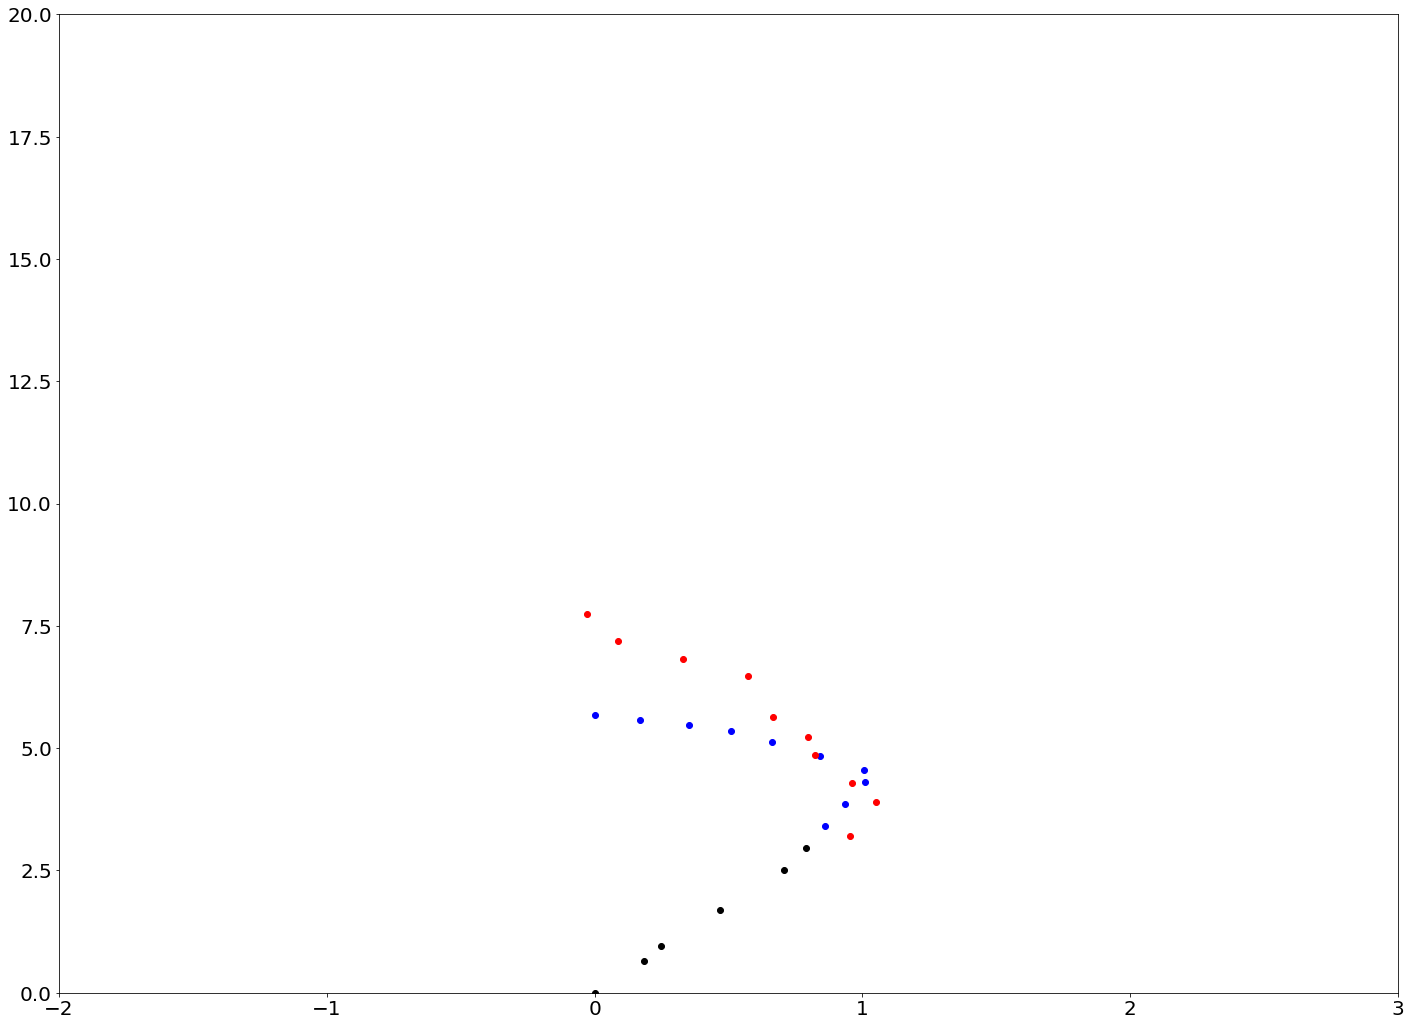

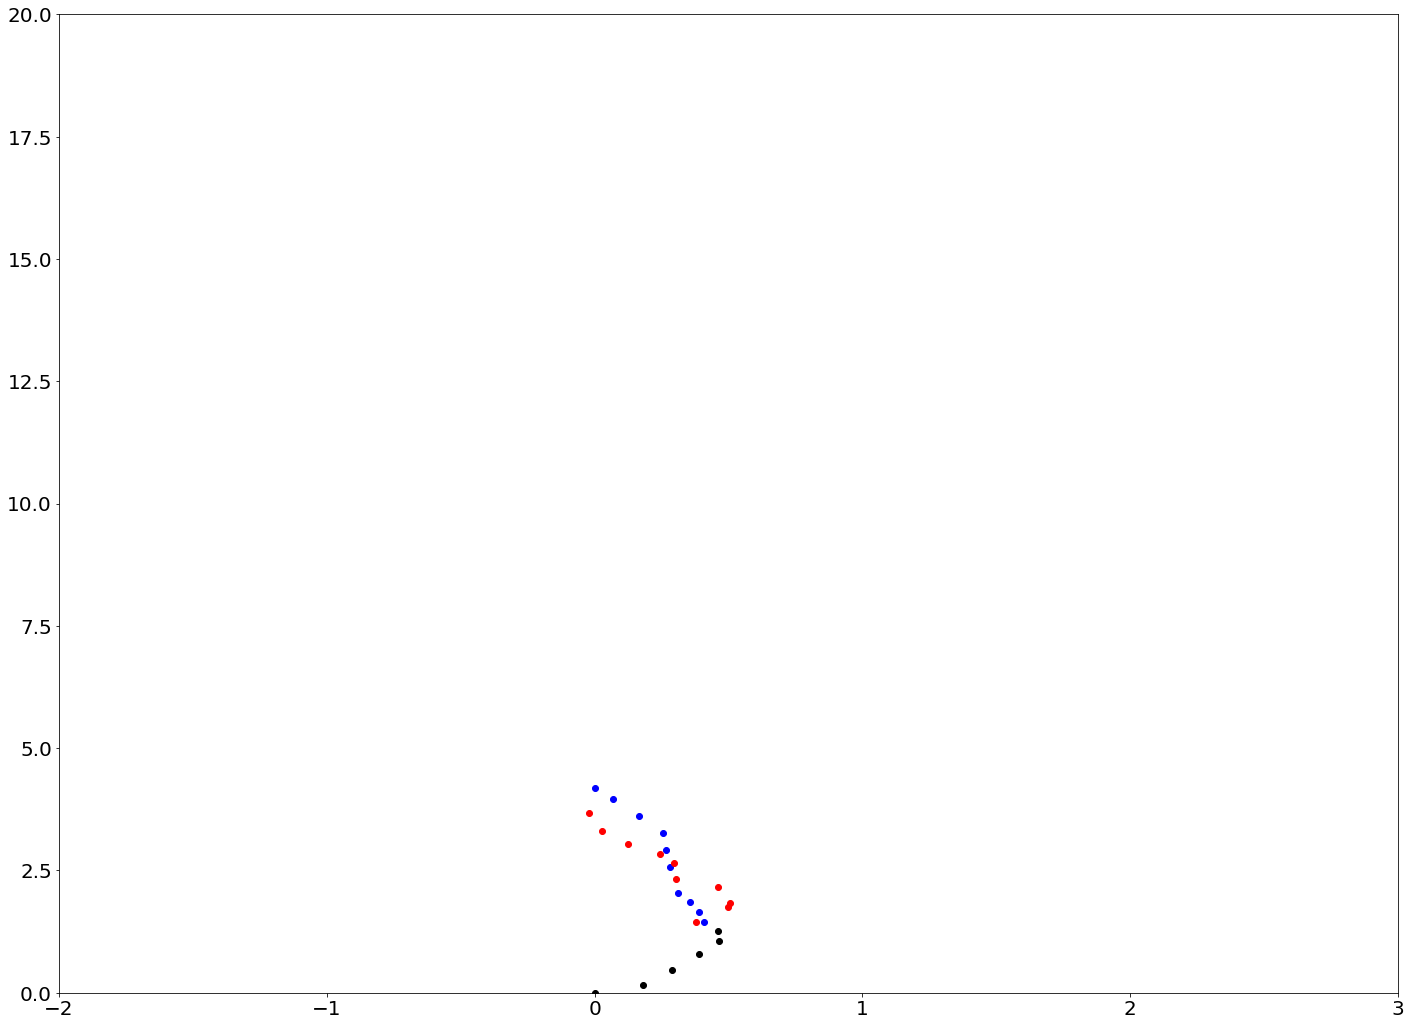

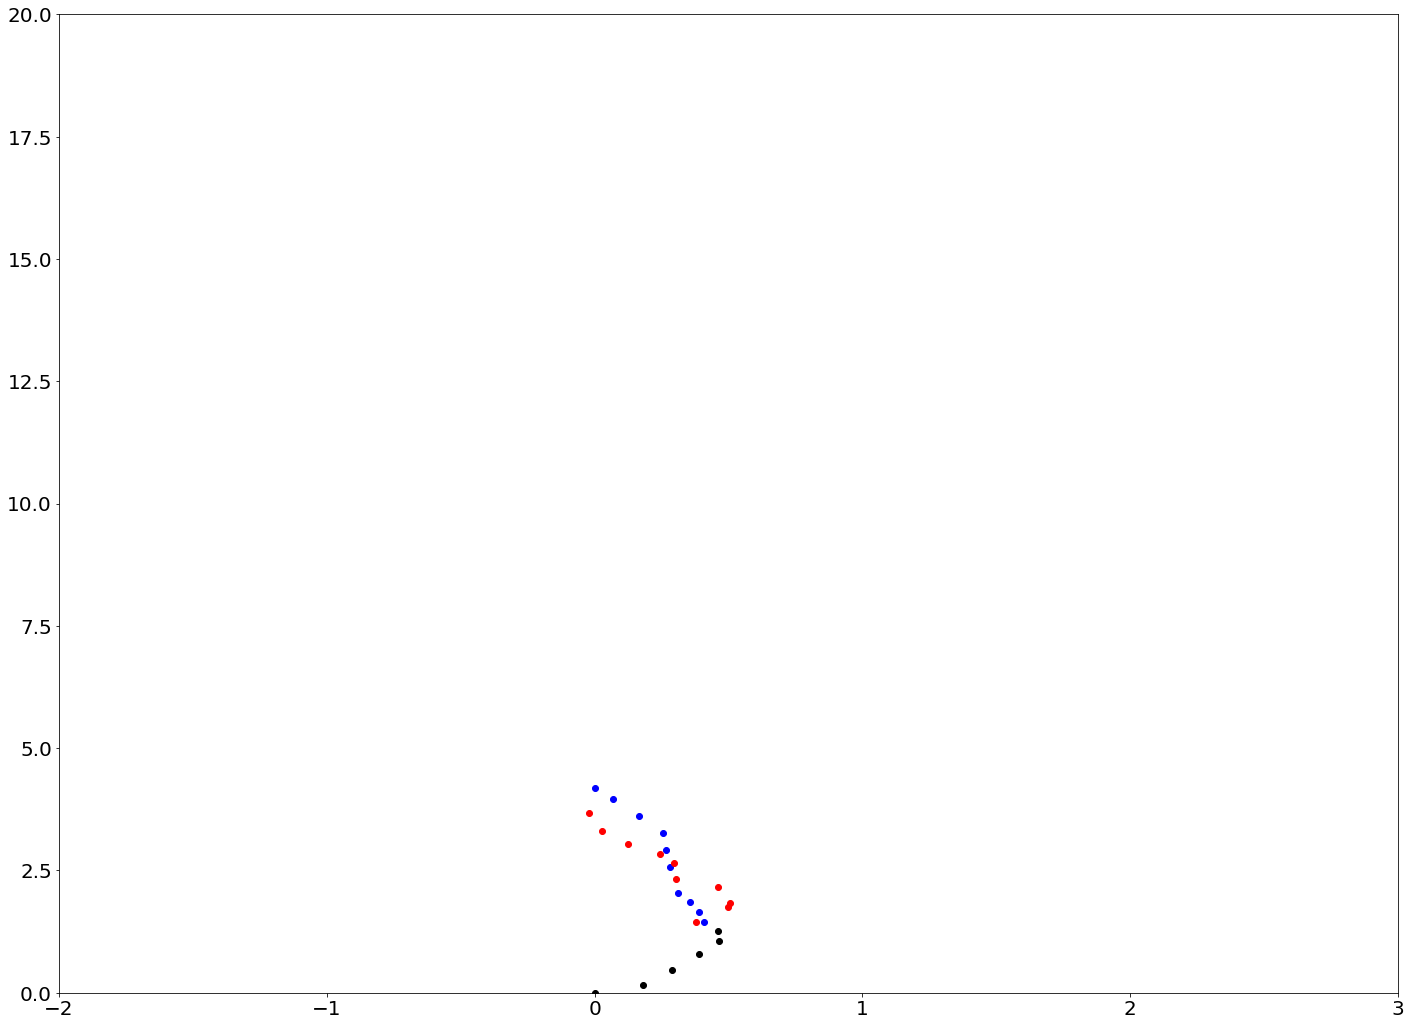

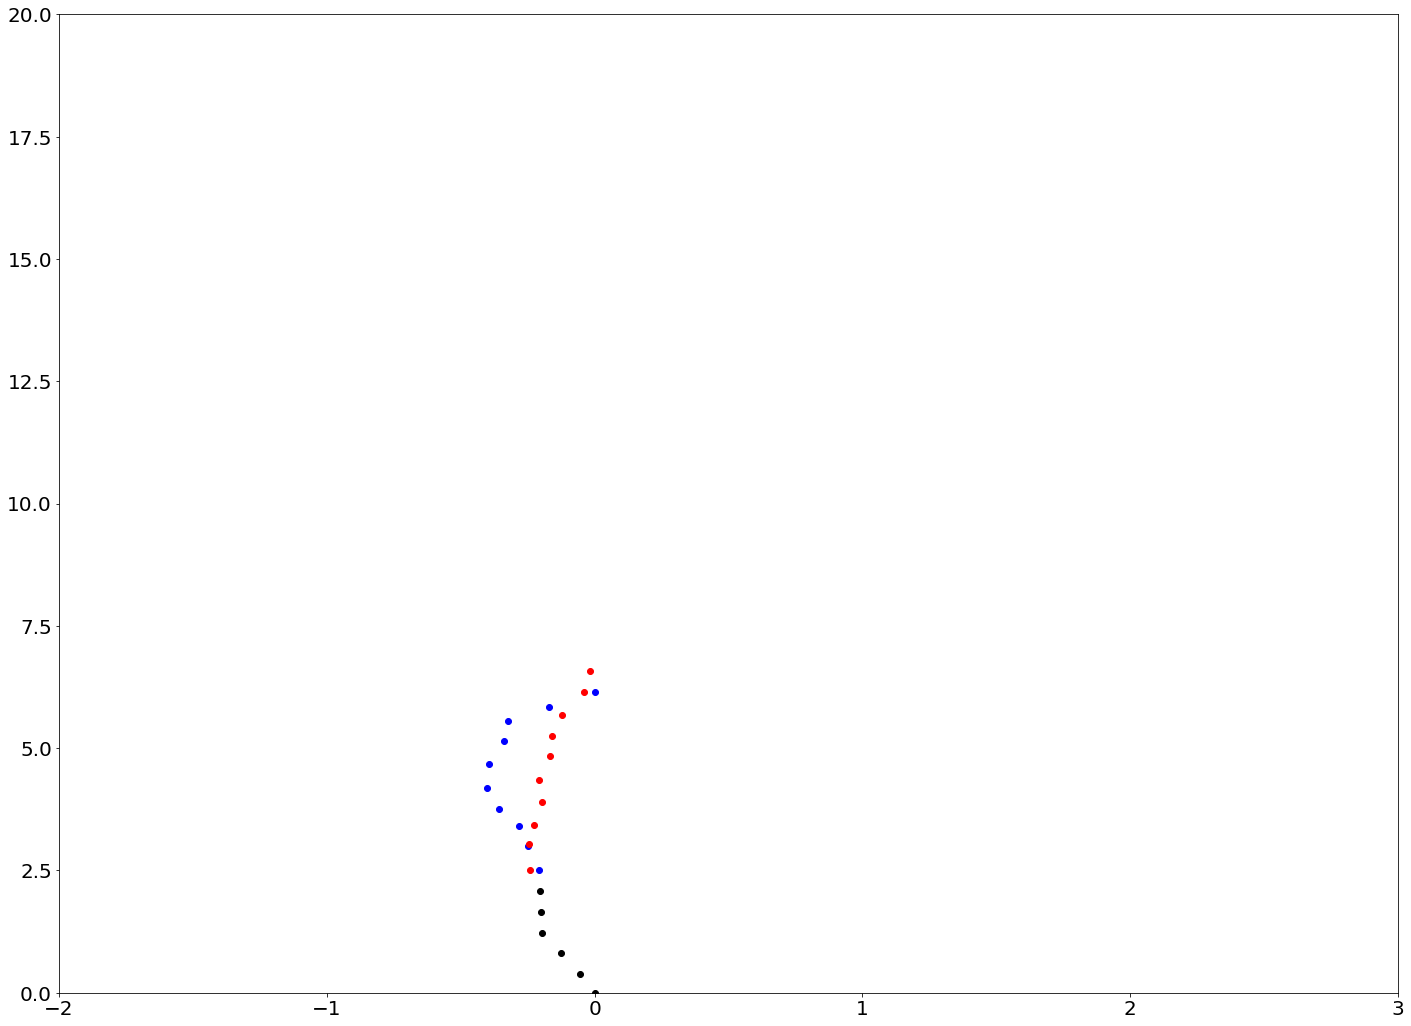

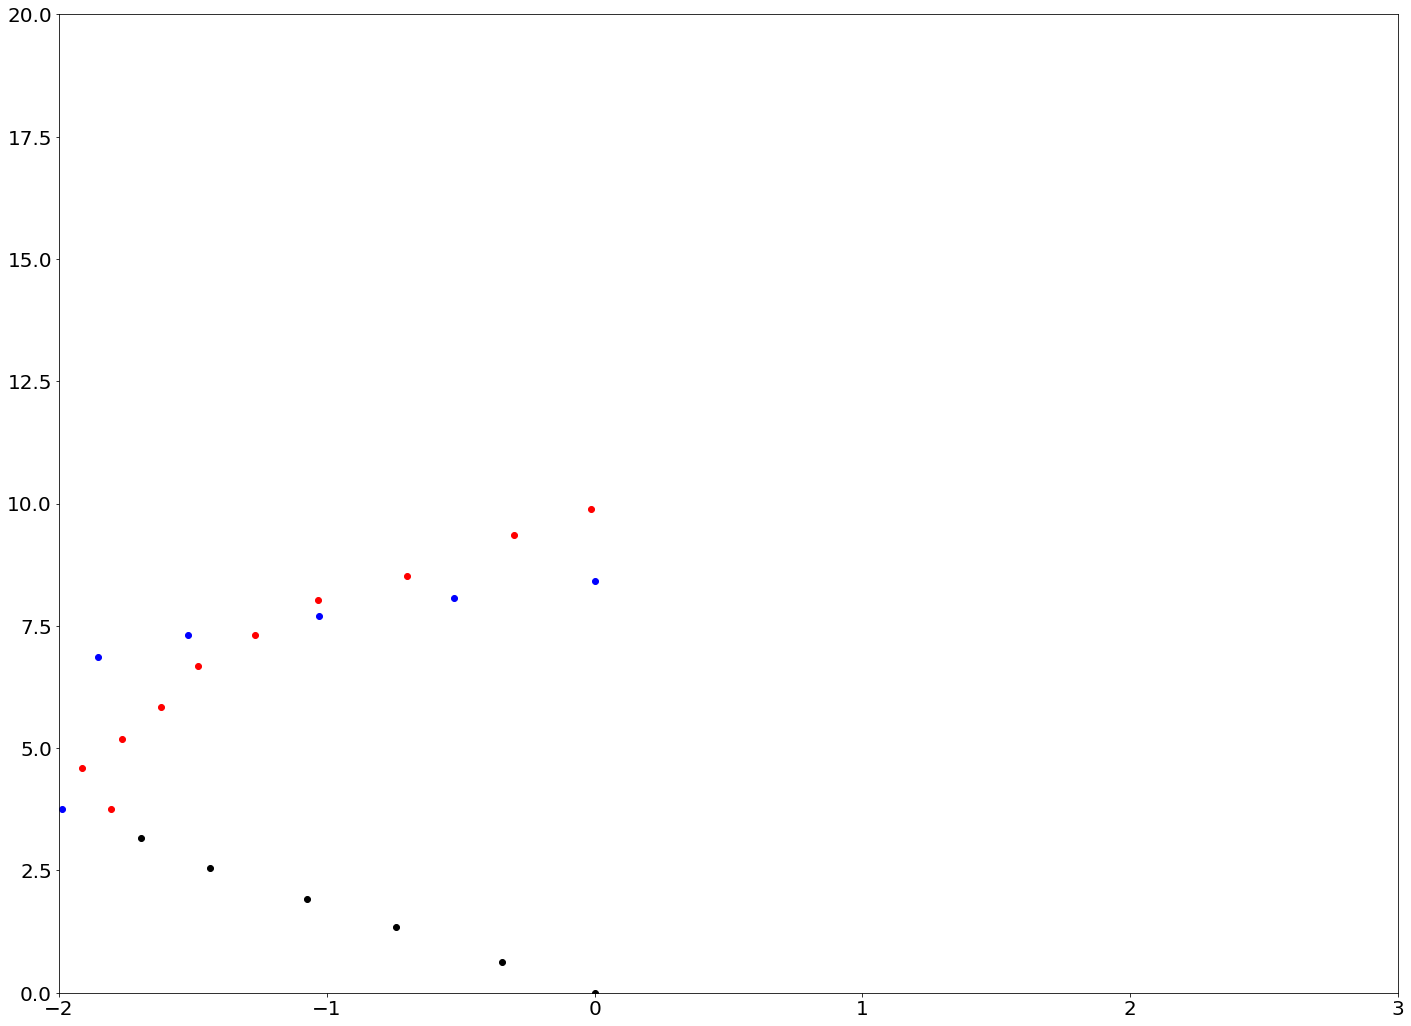

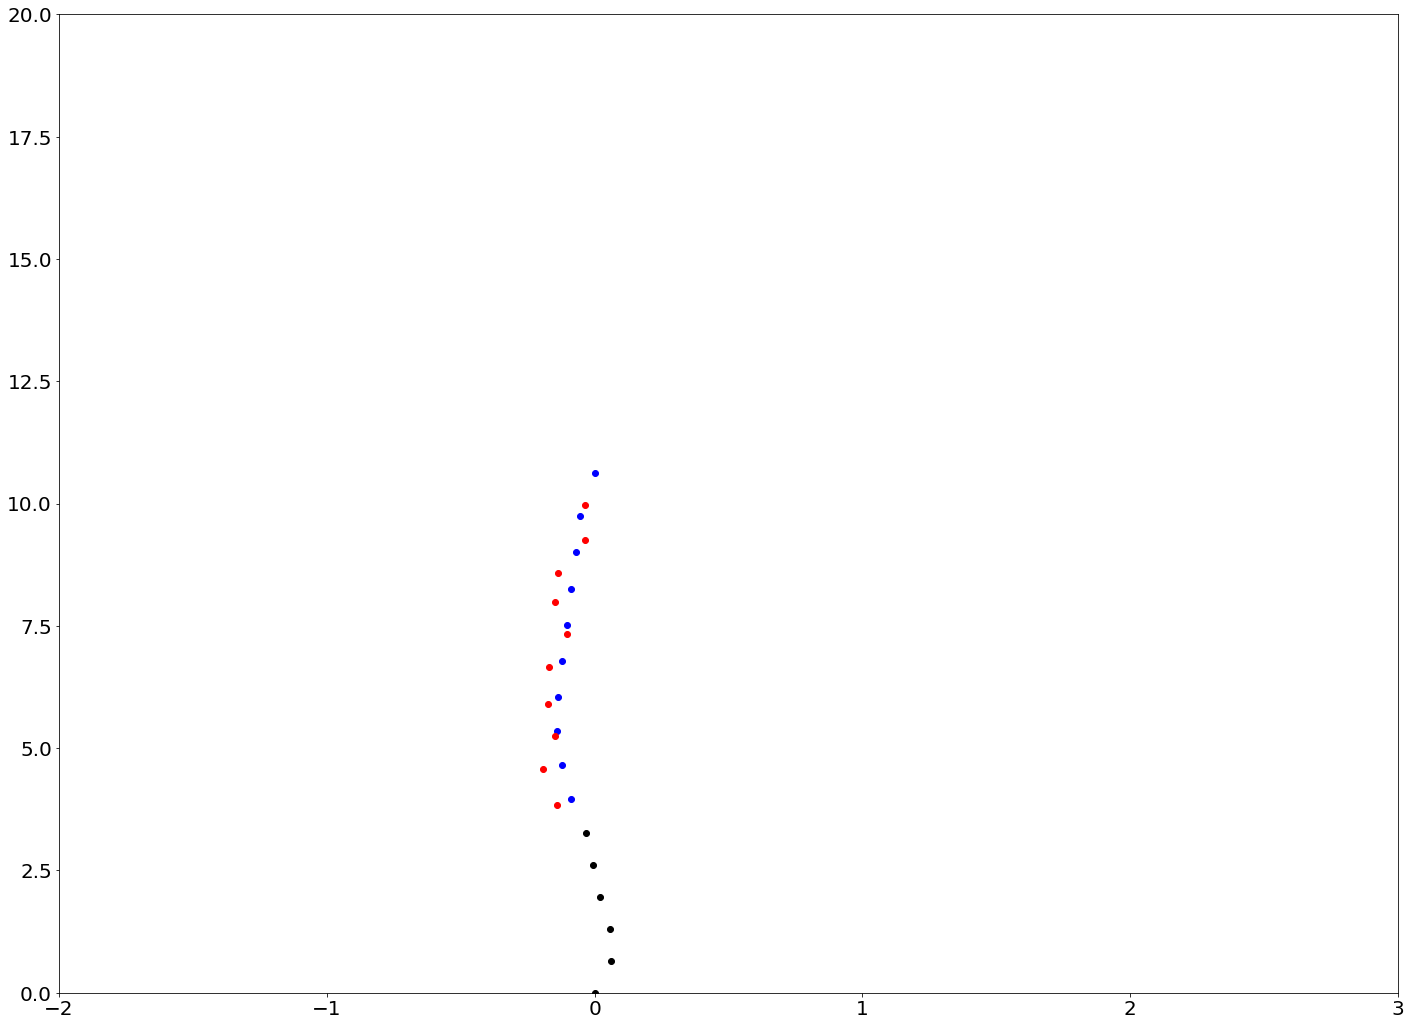

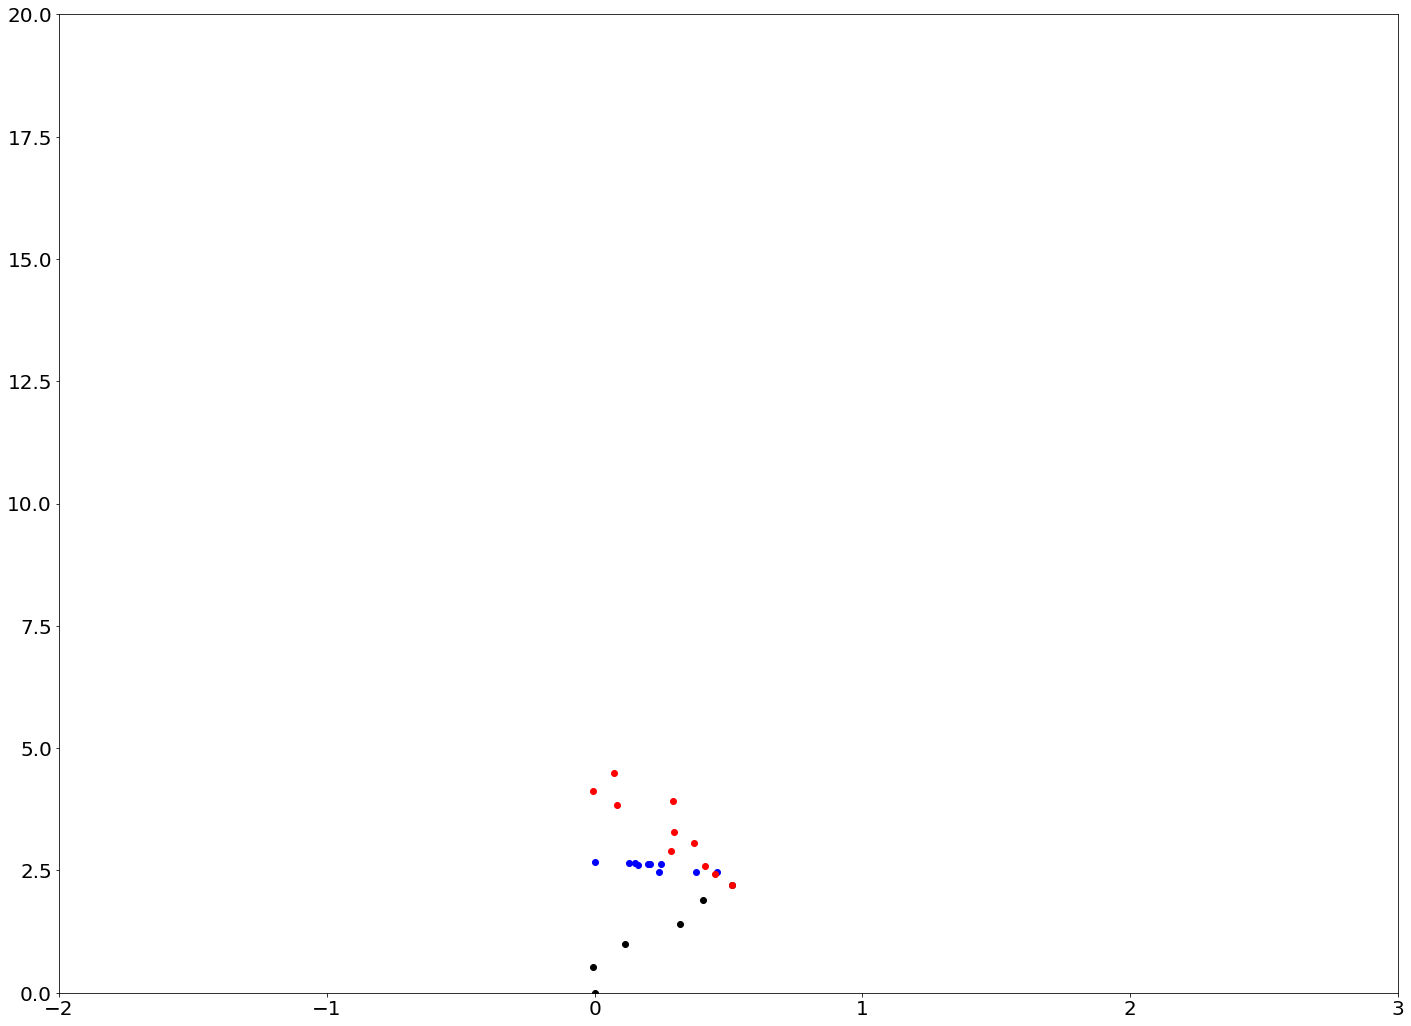

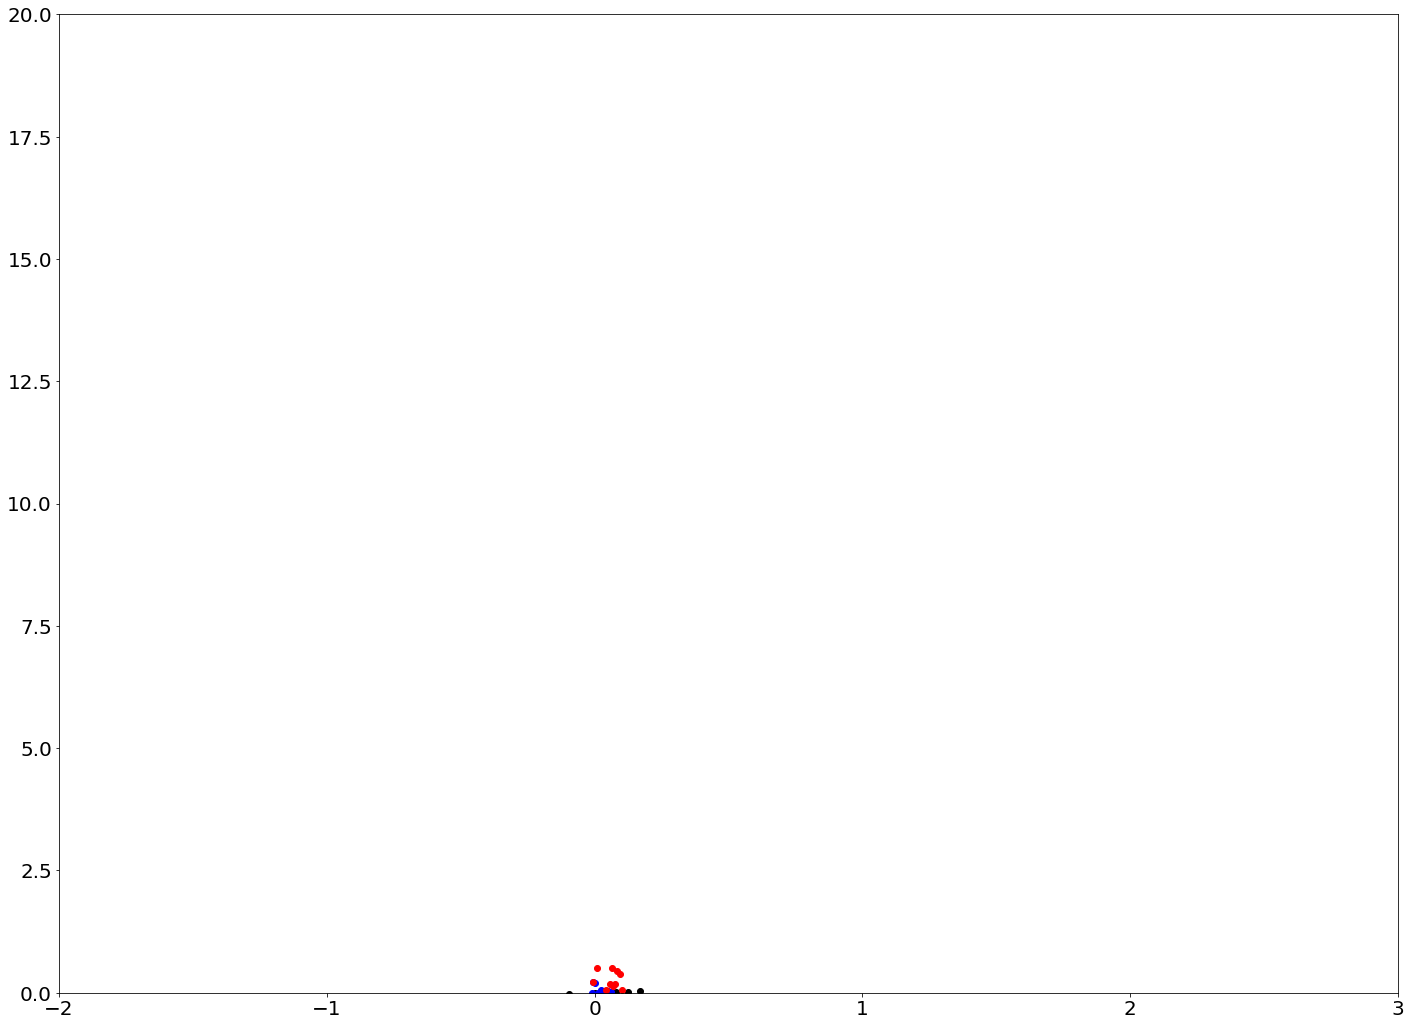

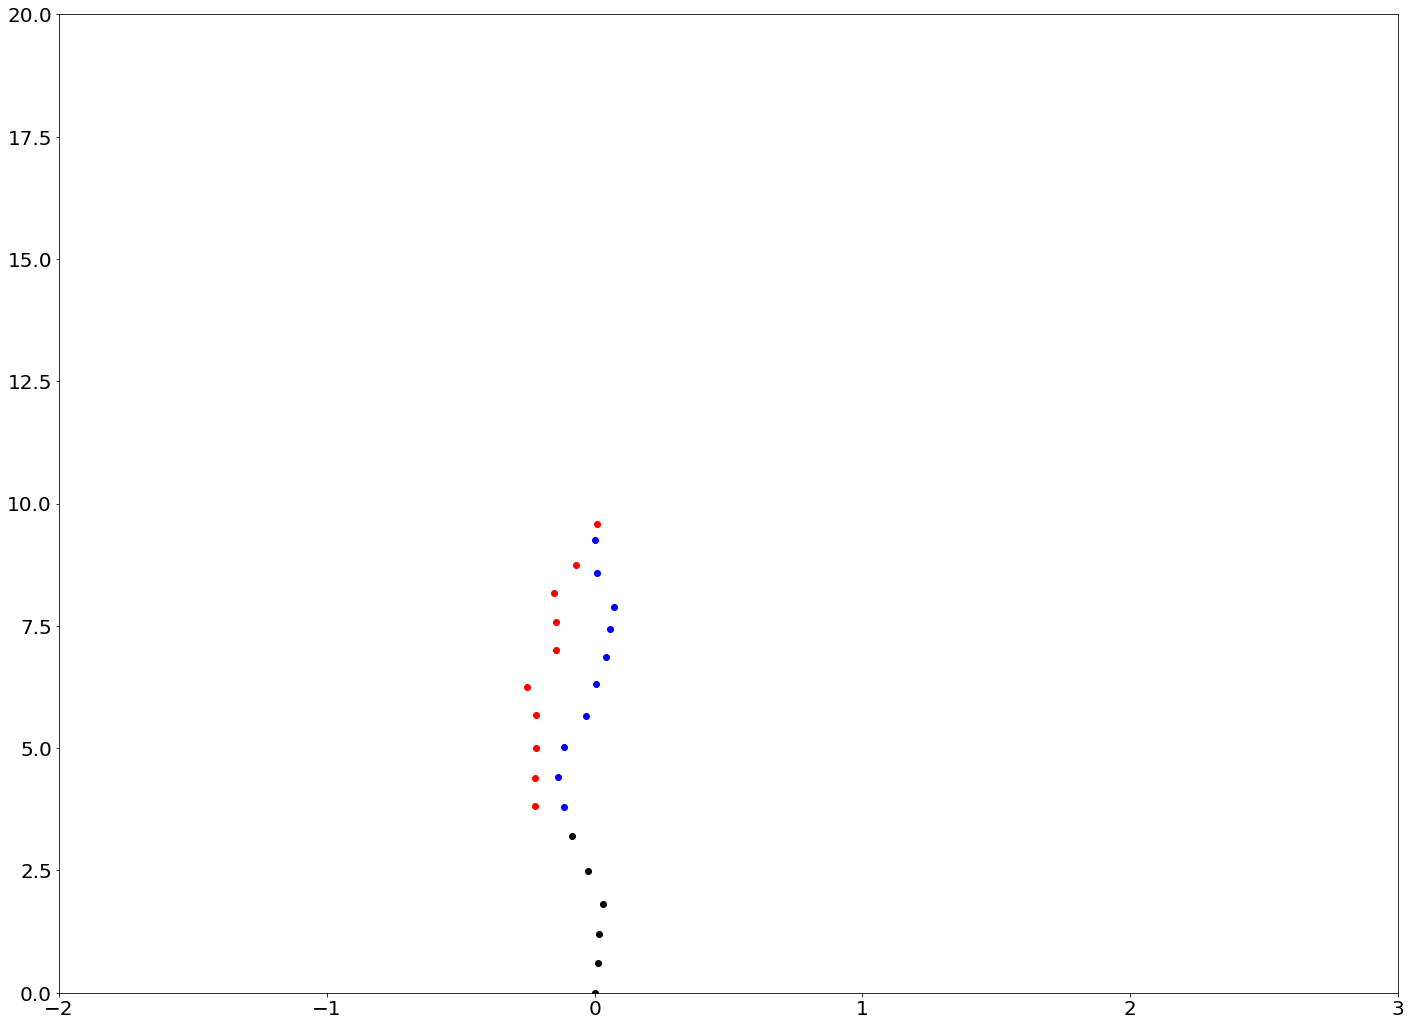

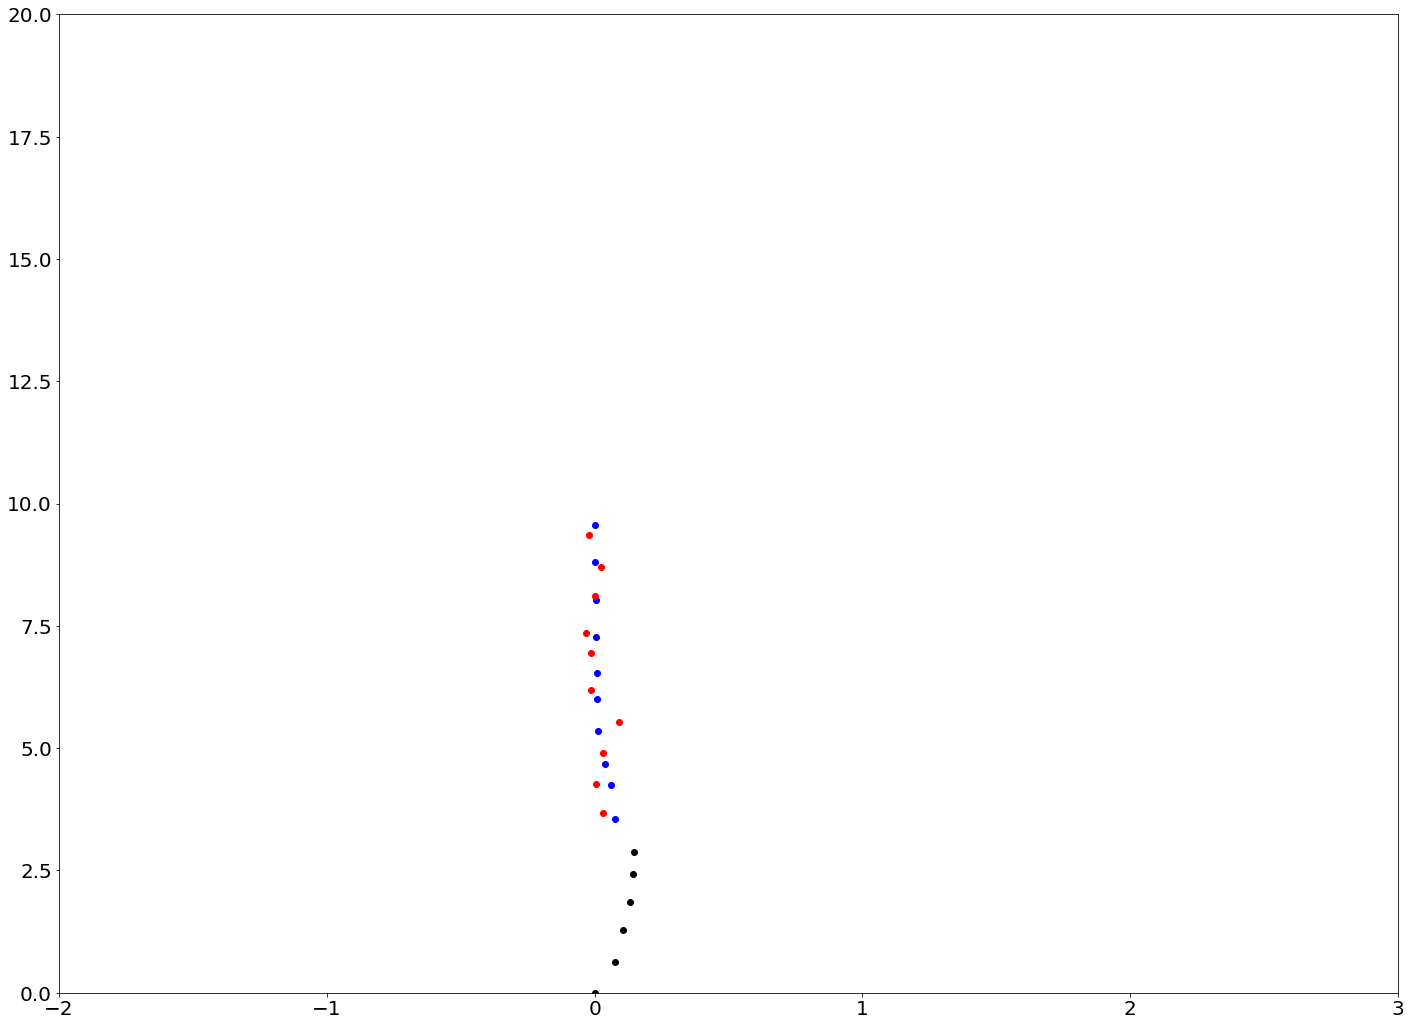

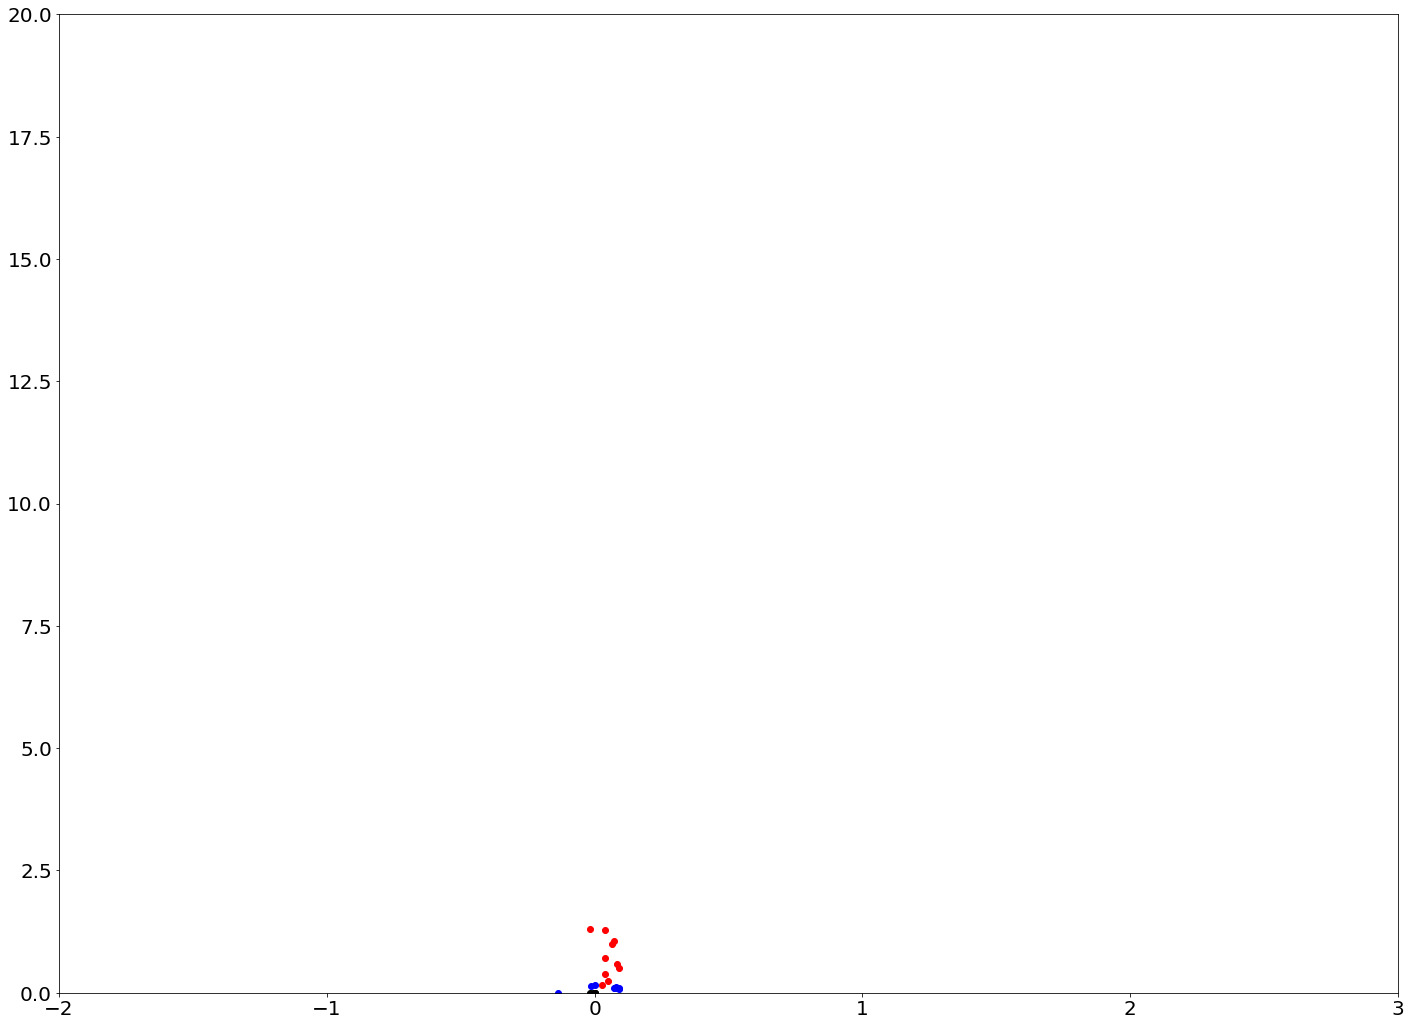

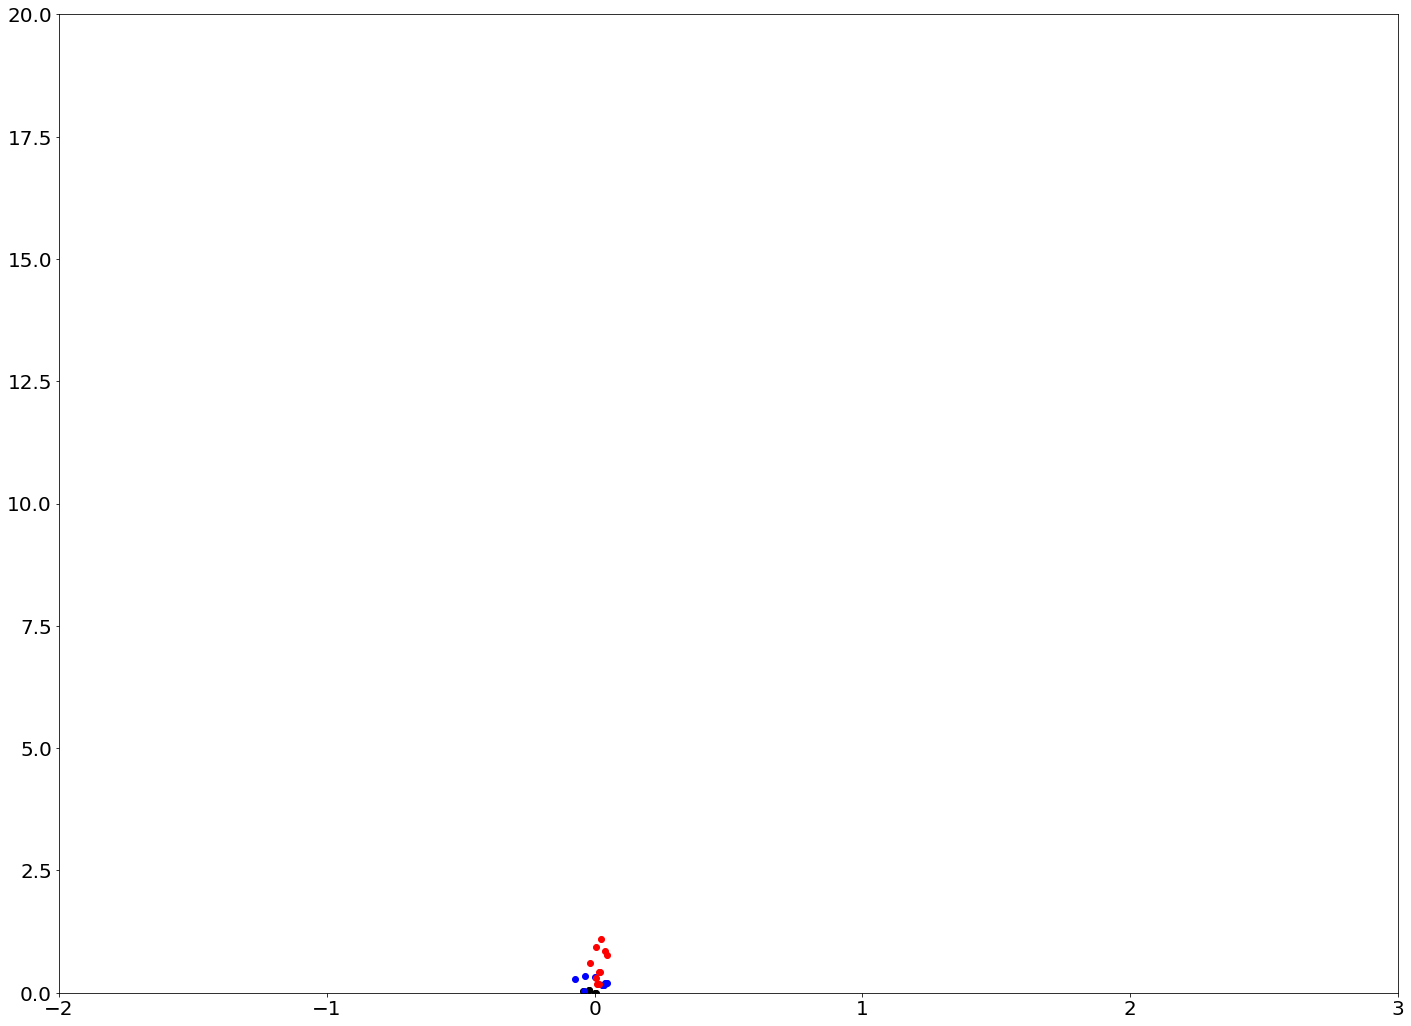

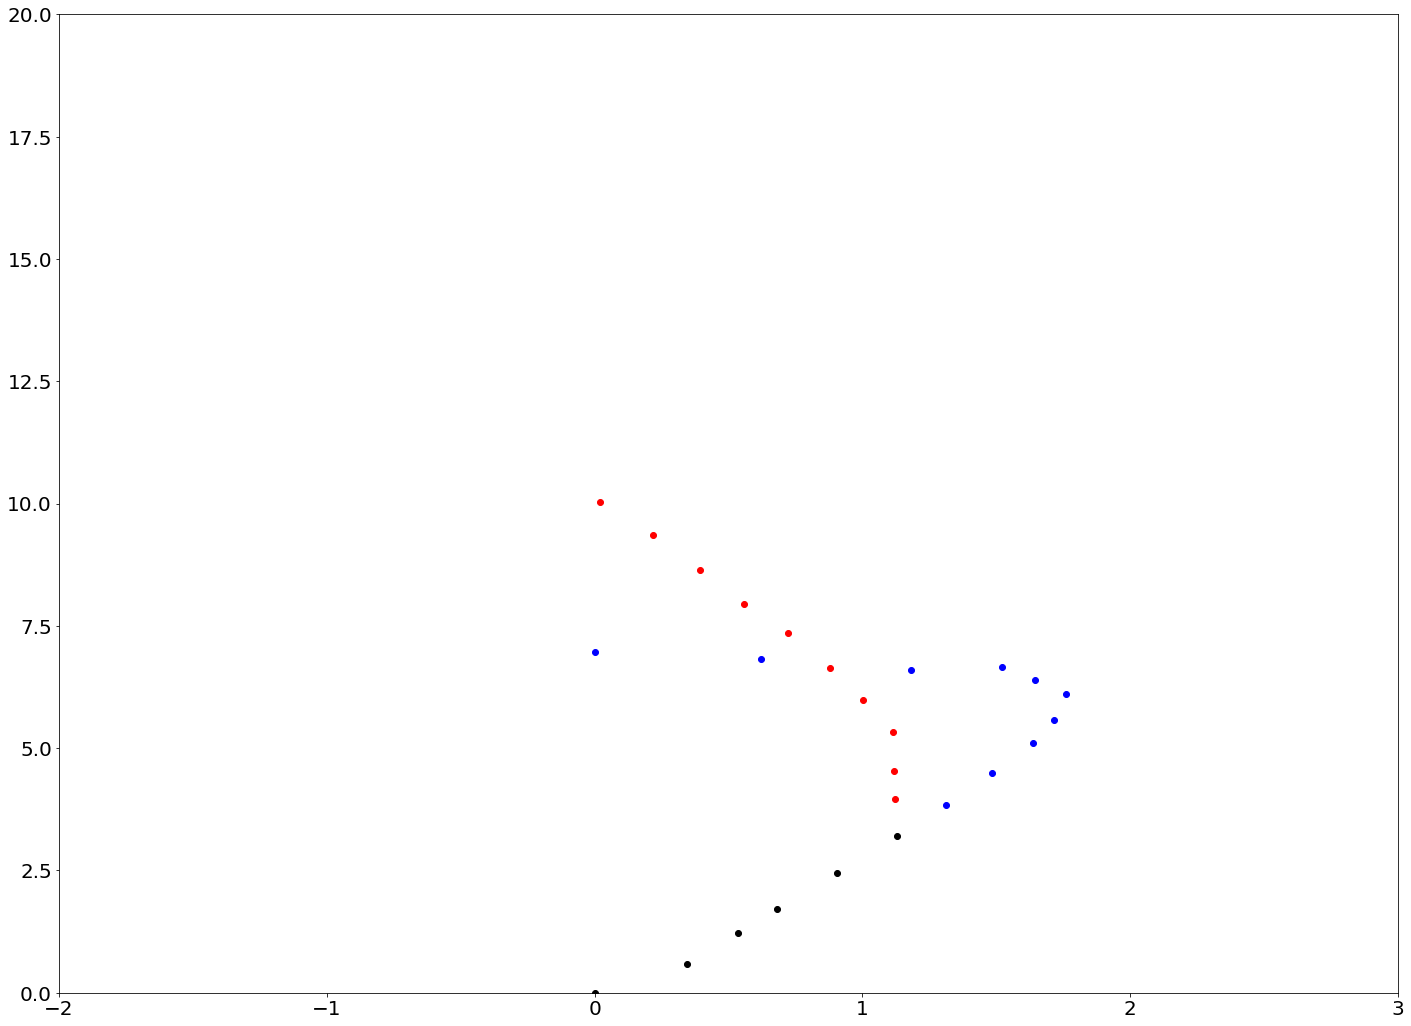

In [38]:
for test_idx in range(40,80):

    predictions = fc_model.predict(np.reshape(test_set[test_idx,:TRAIN_TIME,:], (1, 42))).reshape(-1, 2)

    plt.scatter(*zip(*test_set[test_idx,:6,:2]), c='k')
    plt.scatter(*zip(*test_set[test_idx,6:,:2]), c='b')
    plt.scatter(*zip(*predictions), c='r')
    plt.xlim(-2,3)
    plt.ylim(0,20)
    plt.show()